In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
from neurolib.utils import func_optimize as fo
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
import neurolib.dashboard.layout as layout

    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

not here


In [2]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [3]:
##### LOAD BOUNDARIES
data_file = '..' + os.sep + '..' + os.sep + 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]

In [4]:
bestControl = [None] * len(exc)
bestState = [None] * len(exc)
cost_ = [None] * len(exc)
runtime = [None] * len(exc)
grad = [None] * len(exc)
phi = [None] * len(exc)
costnode = [None] * len(exc)
weights = [None] * len(exc)

In [5]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [6]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

dur = 100
trans_time = 0.8
maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

case = '1'

if case == '1':
    max_I = [3., -3.]
    factor_ws = 1.
    factor_we = 0.
    read_file = '..' + os.sep + 'data_final_2' + os.sep + 'control_1.pickle'

In [7]:
if os.path.isfile(read_file) :
    print("file found")
    
    with open(read_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl = load_array[0]
    bestState = load_array[1]
    cost_ = load_array[2]
    costnode = load_array[3]
    weights = load_array[4]

In [8]:
i_range = [20]
stable_state = np.zeros(( len(exc), 2,2,2, 2))

In [9]:
# get init vars without noise

data.set_parameters(aln)
aln.params.duration = 3000.

control0 = functions.step_control(aln, maxI_ = max_I[1])

# low state without noise
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    stable_state[i,0,0,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,0,1,0] = aln.rates_inh[0,-1]

# high state without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    aln.params.duration = 3000.
    aln.run(control=control0)
    stable_state[i,0,1,0,0] = aln.rates_exc[0,-1]
    stable_state[i,0,1,1,0] = aln.rates_inh[0,-1]
    
    aln.params.duration = dur
    target_det = aln.getZeroTarget()
    target_det[:,0,:] = aln.rates_exc[0,-1]
    target_det[:,1,:] = aln.rates_inh[0,-1]
    
    print('exc low, high ', stable_state[i,0,0,0,0], stable_state[i,0,1,0,0])
    print('inh low, high ', stable_state[i,0,0,1,0], stable_state[i,0,1,1,0])

-------  20 0.4500000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
exc low, high  0.00020800079839487667 35.69070596632364
inh low, high  22.354548572416867 90.39821580372033


In [10]:
# get initial parameters and target states with noise

sigma_ou = 0.1
noise_realizations_final = 10000

# set target with noise
aln.params.sigma_ou = sigma_ou
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = 5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) < 1.:
            print("fell in down state, repeat")
            j -= 1
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    aln.params.duration = dur
    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = np.mean(target_rates_e)
    target[i][:,1,:] = np.mean(target_rates_i)
    
    stable_state[i,1,1,0,0] = target[i][0,0,-1]
    stable_state[i,1,1,1,0] = target[i][0,1,-1]
    stable_state[i,1,1,0,1] = np.std(target_rates_e)
    stable_state[i,1,1,1,1] = np.std(target_rates_i)
    
    
aln.params.duration = 300.
control0 = aln.getZeroControl()
control0[0,0,:500] = -5.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    target_rates_e = []
    target_rates_i = []

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) > 10.:
            print("fell in up state, repeat")
            j -= 1
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    stable_state[i,1,0,0,0] = np.mean(target_rates_e)
    stable_state[i,1,0,1,0] = np.mean(target_rates_i)
    stable_state[i,1,0,0,1] = np.std(target_rates_e)
    stable_state[i,1,0,1,1] = np.std(target_rates_i)
    
print('exc low, high with noise ', stable_state[i,1,0,0,0], stable_state[i,1,1,0,0])
print('inh low, high with noise ', stable_state[i,1,0,1,0], stable_state[i,1,1,1,0])

-------  20 0.4500000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
exc low, high with noise  0.000854906694514212 35.25090352684575
inh low, high with noise  22.49294850015588 90.03585726680804


In [11]:
diff_low = np.zeros(( 83,2 ))
diff_high = np.zeros(( 83,2 ))

for i in i_range:
    print('------  ', i)
    diff_low[i,:] = [stable_state[i,0,0,0,0] - stable_state[i,1,0,0,0],
                stable_state[i,0,0,1,0] - stable_state[i,1,0,1,0]]
    print("difference in low rate exc/ inh: ", diff_low[i,:])
    print("std dev low rate exc/ inh: ", stable_state[i,1,0,0,1], stable_state[i,1,0,1,1])
    diff_high[i,:] =  [stable_state[i,0,1,0,0] - stable_state[i,1,1,0,0],
                 stable_state[i,0,1,1,0] - stable_state[i,1,1,1,0]]
    print("difference in high rate exc/ inh: ", diff_high[i,:])
    print("std dev high rate exc/ inh: ", stable_state[i,1,1,0,1], stable_state[i,1,1,1,1])

------   20
difference in low rate exc/ inh:  [-0.00064691 -0.13839993]
std dev low rate exc/ inh:  0.005024109850554103 4.140156610434526
difference in high rate exc/ inh:  [0.43980244 0.36235854]
std dev high rate exc/ inh:  5.839686175781797 4.454254700351022


In [12]:
print("Max/ min / min abs diff low rate EXC",
      np.amax(diff_low[:,0]), np.amin(diff_low[:,0]), np.amin(np.abs(diff_low[:,0])))
print("Max/ min / min abs diff low rate INH",
      np.amax(diff_low[:,1]), np.amin(diff_low[:,1]), np.amin(np.abs(diff_low[:,1])))
print("Max/ min / min abs diff high rate EXC",
      np.amax(diff_high[:,0]), np.amin(diff_high[:,0]), np.amin(np.abs(diff_high[:,0])))
print("Max/ min / min abs diff high rate INH",
      max(diff_high[:,1]), min(diff_high[:,1]), np.amin(np.abs(diff_high[:,1])))
print('---')
for i in i_range:
    if diff_high[i,0] < 0.:
        print(i, diff_high[i], ' low ', stable_state[i,1,0,:,0], 'high ', stable_state[i,1,1,:,0])
print('---')
for i in i_range:
    if diff_high[i,1] > 0.:
        print(i, diff_high[i], ' low ', stable_state[i,1,0,:,0], 'high ', stable_state[i,1,1,:,0])

Max/ min / min abs diff low rate EXC 0.0 -0.0006469058961193353 0.0
Max/ min / min abs diff low rate INH 0.0 -0.13839992773901244 0.0
Max/ min / min abs diff high rate EXC 0.4398024394778943 0.0 0.0
Max/ min / min abs diff high rate INH 0.36235853691229636 0.0 0.0
---
---
20 [0.43980244 0.36235854]  low  [8.54906695e-04 2.24929485e+01] high  [35.25090353 90.03585727]


In [13]:
init_control_noisefree = bestControl[20]

w_e = 0.
w_s = 1.
w_p = np.zeros(( len(exc) ))

for i in i_range:
    w_p[i] = 1. / ( ( stable_state[i,1,1,0,1] + stable_state[i,1,1,1,1] ) * (1. - trans_time) * dur / aln.params.dt )

In [14]:
dur = 100.
max_it = 10
noise_realizations = 40
noise_realizations_final = 20000
aln.params.sigma_ou = sigma_ou
prec_vars = [0,1]
i = 20

control_list = [None, None, None, None] # 4 methods
cost_list = [None, None, None, None]
mean_cost = [ None, None, None, None ]

In [15]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

aln.params.ext_exc_current = exc[i] * 5.
aln.params.ext_inh_current = inh[i] * 5.

print("------- ", i, exc[i], inh[i], noise_realizations)

##### zero control as input for uncontrolled cost
cost.setParams(w_p[i], w_e, w_s)

m1_control_list = []
m1_cost_list = []

control_list[0] = np.zeros(( zero_init.shape[0], zero_init.shape[1], zero_init.shape[2]+200 ))
cost_list[0] = np.zeros(( max_it+1 ))
cost_n = np.zeros(( max_it + 1 ))

min_it = 10
n_ = 0

while n_  < noise_realizations:
    print("---------", n_)
    mean_cost[0] = []
    setinit(initVars[i], aln)

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=0, init_params = initVars[i])
    
    if cost_[i][min_it] == 0:
        continue
        
    max_jump = 0.
    for v_ in range(bestControl[i].shape[1]):
        for t_ in range(1, bestControl[i].shape[2]):
            diff = np.abs(bestControl[i][0,v_,t_] - bestControl[i][0,v_,t_-1])
            if  diff > max_jump:
                max_jump = diff
                
    if max_jump > 0.5:
        continue
    
    m1_control_list.append(bestControl[i])
    control_list[0] += bestControl[i]
    m1_cost_list.append(cost_[i])
    cost_list[0] += cost_[i]
    
    for c_ in range(len(cost_[i])):
        if cost_[i][c_] != 0.:
            cost_n[c_] += 1
            
    n_ += 1
    
control_list[0] /= noise_realizations
for c_ in range(len(cost_list[0])):
    cost_list[0][c_] /= cost_n[c_]
    
print(cost_list[0])
print('IMPROVEMENT : ', 100. -  100.*cost_list[0][-1]/cost_list[0][0])

-------  20 0.4500000000000001 0.4750000000000002 40
set cost params:  0.00048572262655916665 0.0 1.0
--------- 0
interpolate adjoint :  True True True
initial cost =  136.00220830954274
RUN  0 , total integrated cost =  136.00220830954274
Gradient descend method:  None
RUN  1 , total integrated cost =  42.117385355438095
RUN  2 , total integrated cost =  40.406503256465264
RUN  3 , total integrated cost =  40.58552063768053
RUN  4 , total integrated cost =  40.36462418330472
RUN  5 , total integrated cost =  40.40119921805149
RUN  6 , total integrated cost =  39.839597762515226
RUN  7 , total integrated cost =  39.90061539557219
RUN  8 , total integrated cost =  39.809005371213615
RUN  9 , total integrated cost =  39.620316134215585
RUN  10 , total integrated cost =  39.61935465786453
RUN  10 , total integrated cost =  39.61935465786453
Improved over  10  iterations in  13.504382809000163  seconds by  70.86859459833889  percent.
--------- 0
interpolate adjoint :  True True True
initia

RUN  9 , total integrated cost =  40.12524333431432
RUN  10 , total integrated cost =  40.076779666208
RUN  10 , total integrated cost =  40.076779666208
Improved over  10  iterations in  0.6029020000005403  seconds by  72.17990397265046  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  136.83665264745892
RUN  0 , total integrated cost =  136.83665264745892
Gradient descend method:  None
RUN  1 , total integrated cost =  5.657979403910129
RUN  2 , total integrated cost =  5.927771691860655
RUN  3 , total integrated cost =  6.842450117733774
RUN  4 , total integrated cost =  5.489713412279773
RUN  5 , total integrated cost =  5.0146275222353704
RUN  6 , total integrated cost =  5.4532685431775105
RUN  7 , total integrated cost =  5.066588384344586
RUN  8 , total integrated cost =  5.001497021569752
RUN  9 , total integrated cost =  4.946104636566293
RUN  10 , total integrated cost =  5.338193923042947
RUN  10 , total integrated cost =  5.338193923042947
Improve

RUN  4 , total integrated cost =  7.422713481387461
RUN  5 , total integrated cost =  7.853165587661907
RUN  6 , total integrated cost =  7.7113451206797405
RUN  7 , total integrated cost =  6.560510351482797
RUN  8 , total integrated cost =  6.102788836518309
RUN  9 , total integrated cost =  7.3782865380491005
RUN  10 , total integrated cost =  6.800034499262229
RUN  10 , total integrated cost =  6.800034499262229
Improved over  10  iterations in  0.4064024170002085  seconds by  95.7278848060759  percent.
--------- 6
interpolate adjoint :  True True True
initial cost =  143.1445542670046
RUN  0 , total integrated cost =  143.1445542670046
Gradient descend method:  None
RUN  1 , total integrated cost =  11.945574838278507
RUN  2 , total integrated cost =  10.005260249001353
RUN  3 , total integrated cost =  8.2019757775428
RUN  4 , total integrated cost =  5.404878807094344
RUN  5 , total integrated cost =  7.440301992659258
RUN  6 , total integrated cost =  6.226887512854563
RUN  7 ,

RUN  3 , total integrated cost =  8.470851648720151
RUN  4 , total integrated cost =  6.5156587759769256
RUN  5 , total integrated cost =  6.761224538443722
RUN  6 , total integrated cost =  7.878727665946842
RUN  7 , total integrated cost =  6.7460933627336965
RUN  8 , total integrated cost =  8.613419011448862
RUN  9 , total integrated cost =  6.309160699853107
RUN  10 , total integrated cost =  5.688395178809568
RUN  10 , total integrated cost =  5.688395178809568
Improved over  10  iterations in  0.6347374979995948  seconds by  96.0467527404954  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  132.40984233713635
RUN  0 , total integrated cost =  132.40984233713635
Gradient descend method:  None
RUN  1 , total integrated cost =  41.06223236460645
RUN  2 , total integrated cost =  40.59598431487512
RUN  3 , total integrated cost =  40.1366480086538
RUN  4 , total integrated cost =  40.23348069356966
RUN  5 , total integrated cost =  40.19165506595281
RUN  6

RUN  9 , total integrated cost =  40.048009314853815
RUN  10 , total integrated cost =  40.013759298700265
RUN  10 , total integrated cost =  40.013759298700265
Improved over  10  iterations in  0.4714350739996007  seconds by  71.79894816626836  percent.
--------- 19
interpolate adjoint :  True True True
initial cost =  149.46253279518837
RUN  0 , total integrated cost =  149.46253279518837
Gradient descend method:  None
RUN  1 , total integrated cost =  42.582669428701024
RUN  2 , total integrated cost =  40.303433109382276
RUN  3 , total integrated cost =  39.82323754461952
RUN  4 , total integrated cost =  40.0727637055242
RUN  5 , total integrated cost =  39.859139269316564
RUN  6 , total integrated cost =  40.06924977895902
RUN  7 , total integrated cost =  40.13748240196245
RUN  8 , total integrated cost =  40.15330219440759
RUN  9 , total integrated cost =  40.026516898689536
RUN  10 , total integrated cost =  40.14385832952038
RUN  10 , total integrated cost =  40.1438583295203

RUN  3 , total integrated cost =  39.36241440641109
RUN  4 , total integrated cost =  39.7342903376979
RUN  5 , total integrated cost =  39.623644603282656
RUN  6 , total integrated cost =  40.36912487431573
RUN  7 , total integrated cost =  39.905722538809506
RUN  8 , total integrated cost =  39.75691484457407
RUN  9 , total integrated cost =  40.21980230709206
RUN  10 , total integrated cost =  40.022242272915555
RUN  10 , total integrated cost =  40.022242272915555
Improved over  10  iterations in  0.7052513539993015  seconds by  71.79893671512957  percent.
--------- 25
interpolate adjoint :  True True True
initial cost =  154.25496561228377
RUN  0 , total integrated cost =  154.25496561228377
Gradient descend method:  None
RUN  1 , total integrated cost =  43.25757786333177
RUN  2 , total integrated cost =  40.36377750813071
RUN  3 , total integrated cost =  40.13798445783121
RUN  4 , total integrated cost =  40.09280669686099
RUN  5 , total integrated cost =  39.772166236710845
RU

RUN  6 , total integrated cost =  39.924281341096936
RUN  7 , total integrated cost =  39.917480988913
RUN  8 , total integrated cost =  40.16988833260747
RUN  9 , total integrated cost =  40.01051472425865
RUN  10 , total integrated cost =  40.23901010153083
RUN  10 , total integrated cost =  40.23901010153083
Improved over  10  iterations in  0.491959766999571  seconds by  67.31544002296684  percent.
--------- 30
interpolate adjoint :  True True True
initial cost =  154.47986090874852
RUN  0 , total integrated cost =  154.47986090874852
Gradient descend method:  None
RUN  1 , total integrated cost =  12.087455099176639
RUN  2 , total integrated cost =  7.256103252142183
RUN  3 , total integrated cost =  6.726183391256421
RUN  4 , total integrated cost =  6.693353914034698
RUN  5 , total integrated cost =  6.731111894641213
RUN  6 , total integrated cost =  6.673803568618192
RUN  7 , total integrated cost =  6.319278127715467
RUN  8 , total integrated cost =  6.3565033686691335
RUN  9

RUN  3 , total integrated cost =  5.453840953972394
RUN  4 , total integrated cost =  5.446185572044775
RUN  5 , total integrated cost =  5.6690860440307365
RUN  6 , total integrated cost =  5.385633163662943
RUN  7 , total integrated cost =  5.309342927768507
RUN  8 , total integrated cost =  5.349040759473581
RUN  9 , total integrated cost =  5.483313413496266
RUN  10 , total integrated cost =  5.4569848286940505
RUN  10 , total integrated cost =  5.4569848286940505
Improved over  10  iterations in  0.6090521389996866  seconds by  96.30196592399238  percent.
--------- 38
interpolate adjoint :  True True True
initial cost =  124.10607887482065
RUN  0 , total integrated cost =  124.10607887482065
Gradient descend method:  None
RUN  1 , total integrated cost =  42.15304035063566
RUN  2 , total integrated cost =  40.47092953758617
RUN  3 , total integrated cost =  40.537452422749645
RUN  4 , total integrated cost =  39.78923085346451
RUN  5 , total integrated cost =  39.72814634848028
RU

In [16]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[0][:,:,100:-100]
T = int(1 + dur/aln.params.dt)
dt = aln.params.dt

target_ = target[i].copy()
target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[0].append(np.mean(cost_final))
print('mean = ', mean_cost[0])

/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'var_' of function 'numba_cost_precision_int'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../neurolib/utils/costFunctions.py", line 79:
@numba.njit
def numba_cost_precision_int(N, T, dt, i_p, state_, target_state_, var_):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


mean =  [66.57849802267005]


In [17]:
for k_ in range(19):
    print('-------------------------------------------------------------------', k_)

    aln.params.duration = dur

    n_ = 0
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[0][:,:,100:-100]

    while n_  < noise_realizations:
        print("---------", n_)
        setinit(initVars[i], aln)

        bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
            init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real=0, init_params = initVars[i])

        if cost_[i][min_it] == 0:
            continue

        max_jump = 0.
        for v_ in range(bestControl[i].shape[1]):
            for t_ in range(1, bestControl[i].shape[2]):
                diff = np.abs(bestControl[i][0,v_,t_] - bestControl[i][0,v_,t_-1])
                if  diff > max_jump:
                    max_jump = diff

        if max_jump > 0.5:
            continue

        m1_control_list.append(bestControl[i])
        control_list[0] += bestControl[i]
        m1_cost_list.append(cost_[i])
        cost_list[0] += cost_[i]

        n_ += 1

    control_list[0] /= noise_realizations


    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[0][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[0].append(np.mean(cost_final))
    
print('mean = ', mean_cost[0])

------------------------------------------------------------------- 0
--------- 0
interpolate adjoint :  True True True
initial cost =  87.39875896808778
RUN  0 , total integrated cost =  87.39875896808778
Gradient descend method:  None
RUN  1 , total integrated cost =  18.309724867935635
RUN  2 , total integrated cost =  8.47713734406701
RUN  3 , total integrated cost =  6.228649108512736
RUN  4 , total integrated cost =  5.037035738619701
RUN  5 , total integrated cost =  5.089770471544296
RUN  6 , total integrated cost =  5.422960487470732
RUN  7 , total integrated cost =  5.386113923334296
RUN  8 , total integrated cost =  5.852551074113927
RUN  9 , total integrated cost =  5.217650708411411
RUN  10 , total integrated cost =  4.914984128078548
RUN  10 , total integrated cost =  4.914984128078548
Improved over  10  iterations in  0.6069481570002608  seconds by  94.37636851356989  percent.
--------- 1
interpolate adjoint :  True True True
initial cost =  82.31160882522005
RUN  0 , to

RUN  1 , total integrated cost =  15.28009771885091
RUN  2 , total integrated cost =  7.084005031227167
RUN  3 , total integrated cost =  6.379923633689735
RUN  4 , total integrated cost =  6.264453624617308
RUN  5 , total integrated cost =  6.630149852055437
RUN  6 , total integrated cost =  6.572632678258373
RUN  7 , total integrated cost =  5.98534736265542
RUN  8 , total integrated cost =  6.087639419372364
RUN  9 , total integrated cost =  5.729143826775958
RUN  10 , total integrated cost =  5.837133833876226
RUN  10 , total integrated cost =  5.837133833876226
Improved over  10  iterations in  0.8769891130004908  seconds by  89.13767206467097  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  65.24477884121376
RUN  0 , total integrated cost =  65.24477884121376
Gradient descend method:  None
RUN  1 , total integrated cost =  15.966974075259309
RUN  2 , total integrated cost =  6.4608096492075
RUN  3 , total integrated cost =  5.6393555674472955
RUN  4 , 

RUN  2 , total integrated cost =  10.190833380192569
RUN  3 , total integrated cost =  9.60737129944479
RUN  4 , total integrated cost =  6.739836032835726
RUN  5 , total integrated cost =  6.825574823680089
RUN  6 , total integrated cost =  6.524442887577975
RUN  7 , total integrated cost =  6.341840520810642
RUN  8 , total integrated cost =  5.894105245874533
RUN  9 , total integrated cost =  10.133051386933504
RUN  10 , total integrated cost =  5.866012480628099
RUN  10 , total integrated cost =  5.866012480628099
Improved over  10  iterations in  0.6852267489994119  seconds by  88.73394099381028  percent.
--------- 20
interpolate adjoint :  True True True
initial cost =  70.04323716168531
RUN  0 , total integrated cost =  70.04323716168531
Gradient descend method:  None
RUN  1 , total integrated cost =  16.761476618775927
RUN  2 , total integrated cost =  7.277788761925807
RUN  3 , total integrated cost =  6.5970911551721985
RUN  4 , total integrated cost =  6.0845222396417995
RUN 

RUN  9 , total integrated cost =  5.375193458960851
RUN  10 , total integrated cost =  5.203575715731102
RUN  10 , total integrated cost =  5.203575715731102
Improved over  10  iterations in  0.803146629999901  seconds by  87.64269993897769  percent.
--------- 29
interpolate adjoint :  True True True
initial cost =  74.05672206760275
RUN  0 , total integrated cost =  74.05672206760275
Gradient descend method:  None
RUN  1 , total integrated cost =  15.867222367262173
RUN  2 , total integrated cost =  14.515138788230578
RUN  3 , total integrated cost =  13.343510904155435
RUN  4 , total integrated cost =  14.112718063327552
RUN  5 , total integrated cost =  13.739867412498988
RUN  6 , total integrated cost =  14.856875712423331
RUN  7 , total integrated cost =  13.74298091100361
Control only changes marginally.
RUN  7 , total integrated cost =  13.74298091100361
Improved over  7  iterations in  0.6667006540001239  seconds by  81.44262866717445  percent.
--------- 29
interpolate adjoint 

RUN  10 , total integrated cost =  6.987842908102511
RUN  10 , total integrated cost =  6.987842908102511
Improved over  10  iterations in  0.643863870000132  seconds by  91.30958190438888  percent.
--------- 38
interpolate adjoint :  True True True
initial cost =  72.84262835299134
RUN  0 , total integrated cost =  72.84262835299134
Gradient descend method:  None
RUN  1 , total integrated cost =  17.367650565190004
RUN  2 , total integrated cost =  13.26111878038457
RUN  3 , total integrated cost =  12.715954263425818
RUN  4 , total integrated cost =  15.296579326328988
RUN  5 , total integrated cost =  17.701110540883136
RUN  6 , total integrated cost =  5.935407440802206
RUN  7 , total integrated cost =  5.91937775684593
RUN  8 , total integrated cost =  5.550114376487826
RUN  9 , total integrated cost =  5.561314430226785
RUN  10 , total integrated cost =  5.67903968233694
RUN  10 , total integrated cost =  5.67903968233694
Improved over  10  iterations in  0.5530992220001281  seco

RUN  7 , total integrated cost =  5.813190577499511
RUN  8 , total integrated cost =  5.112958368239883
RUN  9 , total integrated cost =  5.693186492341839
RUN  10 , total integrated cost =  5.438363493055065
RUN  10 , total integrated cost =  5.438363493055065
Improved over  10  iterations in  0.6021134470001925  seconds by  14.353125239352963  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  5.72428300343792
RUN  0 , total integrated cost =  5.72428300343792
Gradient descend method:  None
RUN  1 , total integrated cost =  5.35567095545345
RUN  2 , total integrated cost =  5.232789600957686
RUN  3 , total integrated cost =  5.258466743120933
RUN  4 , total integrated cost =  5.783656110991208
RUN  5 , total integrated cost =  4.688198996527271
RUN  6 , total integrated cost =  5.498812401497778
RUN  7 , total integrated cost =  5.5396535497737185
RUN  8 , total integrated cost =  5.377073951831164
RUN  9 , total integrated cost =  4.8262453718383895
RUN  10 ,

RUN  9 , total integrated cost =  5.230737753925333
RUN  10 , total integrated cost =  5.52733218241588
RUN  10 , total integrated cost =  5.52733218241588
Improved over  10  iterations in  0.48233291099950293  seconds by  23.566405114082585  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  6.19883775392488
RUN  0 , total integrated cost =  6.19883775392488
Gradient descend method:  None
RUN  1 , total integrated cost =  5.709326390484569
RUN  2 , total integrated cost =  5.733633383022267
RUN  3 , total integrated cost =  5.385187891590363
RUN  4 , total integrated cost =  5.475636491757032
RUN  5 , total integrated cost =  6.00494888729428
RUN  6 , total integrated cost =  5.692193733563835
RUN  7 , total integrated cost =  6.007847807402717
RUN  8 , total integrated cost =  6.03815954406638
RUN  9 , total integrated cost =  5.77804785790933
RUN  10 , total integrated cost =  5.768015203132432
RUN  10 , total integrated cost =  5.768015203132432
Improved ov

RUN  4 , total integrated cost =  4.967075769349376
RUN  5 , total integrated cost =  5.888560085906272
RUN  6 , total integrated cost =  5.80808191669531
RUN  7 , total integrated cost =  5.627303155804268
RUN  8 , total integrated cost =  5.685086160893565
RUN  9 , total integrated cost =  5.83389507298317
RUN  10 , total integrated cost =  5.610153046925829
RUN  10 , total integrated cost =  5.610153046925829
Improved over  10  iterations in  0.8531986210000468  seconds by  4.310646211839625  percent.
--------- 26
interpolate adjoint :  True True True
initial cost =  6.491167126626873
RUN  0 , total integrated cost =  6.491167126626873
Gradient descend method:  None
RUN  1 , total integrated cost =  5.105067420118827
RUN  2 , total integrated cost =  6.005635932062452
RUN  3 , total integrated cost =  5.67067748209421
RUN  4 , total integrated cost =  5.717707707403502
RUN  5 , total integrated cost =  5.065661805071675
RUN  6 , total integrated cost =  5.717028396709955
RUN  7 , to

RUN  3 , total integrated cost =  6.110685927705592
RUN  4 , total integrated cost =  5.50752941808216
RUN  5 , total integrated cost =  5.608335643513328
RUN  6 , total integrated cost =  5.064948055932899
RUN  7 , total integrated cost =  5.330401822885076
RUN  8 , total integrated cost =  5.378211786605904
RUN  9 , total integrated cost =  5.157187112499787
RUN  10 , total integrated cost =  5.353017502010927
RUN  10 , total integrated cost =  5.353017502010927
Improved over  10  iterations in  0.7110409659999277  seconds by  36.09380015149721  percent.
--------- 36
interpolate adjoint :  True True True
initial cost =  6.372903492524992
RUN  0 , total integrated cost =  6.372903492524992
Gradient descend method:  None
RUN  1 , total integrated cost =  5.3548571113728505
RUN  2 , total integrated cost =  5.588713900111122
RUN  3 , total integrated cost =  5.359299210469212
RUN  4 , total integrated cost =  4.980854214791584
RUN  5 , total integrated cost =  4.889831339602329
RUN  6 ,

RUN  4 , total integrated cost =  6.034218900297635
RUN  5 , total integrated cost =  5.7736371040996515
RUN  6 , total integrated cost =  5.7226420800754685
RUN  7 , total integrated cost =  5.762377244684009
RUN  8 , total integrated cost =  5.536826423726735
RUN  9 , total integrated cost =  5.491263294696331
RUN  10 , total integrated cost =  5.319699924674333
RUN  10 , total integrated cost =  5.319699924674333
Improved over  10  iterations in  0.4434159419997741  seconds by  26.68562818715482  percent.
--------- 6
interpolate adjoint :  True True True
initial cost =  7.605052947349028
RUN  0 , total integrated cost =  7.605052947349028
Gradient descend method:  None
RUN  1 , total integrated cost =  5.66872749868521
RUN  2 , total integrated cost =  5.391590223770225
RUN  3 , total integrated cost =  4.472519422999563
RUN  4 , total integrated cost =  5.313231837981784
RUN  5 , total integrated cost =  5.972843095281121
RUN  6 , total integrated cost =  5.0435604101611204
RUN  7 

RUN  2 , total integrated cost =  5.989324133082592
RUN  3 , total integrated cost =  5.925841303912374
RUN  4 , total integrated cost =  5.683156410011883
RUN  5 , total integrated cost =  5.908498856708038
RUN  6 , total integrated cost =  5.341489754901091
RUN  7 , total integrated cost =  5.469741608127915
RUN  8 , total integrated cost =  5.570429539218835
RUN  9 , total integrated cost =  5.820933845315319
RUN  10 , total integrated cost =  5.883033709827492
RUN  10 , total integrated cost =  5.883033709827492
Improved over  10  iterations in  0.6000461349995021  seconds by  3.4096995396063647  percent.
--------- 16
interpolate adjoint :  True True True
initial cost =  5.773782991717036
RUN  0 , total integrated cost =  5.773782991717036
Gradient descend method:  None
RUN  1 , total integrated cost =  5.462336638554693
RUN  2 , total integrated cost =  5.466156133365288
RUN  3 , total integrated cost =  5.461712066926118
RUN  4 , total integrated cost =  5.505555373905569
RUN  5 

RUN  1 , total integrated cost =  5.837772228654492
RUN  2 , total integrated cost =  5.488456971928491
RUN  3 , total integrated cost =  5.793260926293791
RUN  4 , total integrated cost =  5.363593571836659
RUN  5 , total integrated cost =  5.376623866605461
RUN  6 , total integrated cost =  5.132173567621253
RUN  7 , total integrated cost =  5.140230369812489
RUN  8 , total integrated cost =  5.1222358682363724
RUN  9 , total integrated cost =  5.13264831389128
Control only changes marginally.
RUN  9 , total integrated cost =  5.13264831389128
Improved over  9  iterations in  0.46994367000024795  seconds by  20.956052710207146  percent.
--------- 25
interpolate adjoint :  True True True
initial cost =  7.126258851149912
RUN  0 , total integrated cost =  7.126258851149912
Gradient descend method:  None
RUN  1 , total integrated cost =  5.164341296900675
RUN  2 , total integrated cost =  5.692070926063482
RUN  3 , total integrated cost =  5.5469115390410595
RUN  4 , total integrated co

RUN  1 , total integrated cost =  5.253584305159855
RUN  2 , total integrated cost =  4.833180090738275
RUN  3 , total integrated cost =  4.734596419401051
RUN  4 , total integrated cost =  4.809357197175538
RUN  5 , total integrated cost =  5.626191600366597
RUN  6 , total integrated cost =  5.1612115462310655
RUN  7 , total integrated cost =  5.15039207852879
RUN  8 , total integrated cost =  5.117442285057967
RUN  9 , total integrated cost =  5.558334452614961
RUN  10 , total integrated cost =  5.342229969519771
RUN  10 , total integrated cost =  5.342229969519771
Improved over  10  iterations in  0.8474294640000153  seconds by  48.97406422771196  percent.
--------- 33
interpolate adjoint :  True True True
initial cost =  6.6846879210120465
RUN  0 , total integrated cost =  6.6846879210120465
Gradient descend method:  None
RUN  1 , total integrated cost =  5.383506022420735
RUN  2 , total integrated cost =  5.497453508878817
RUN  3 , total integrated cost =  6.664706103269557
RUN  4

RUN  3 , total integrated cost =  5.623696837402735
RUN  4 , total integrated cost =  4.805752739868393
RUN  5 , total integrated cost =  5.778750733872396
RUN  6 , total integrated cost =  5.923669107961779
RUN  7 , total integrated cost =  5.461157806577543
RUN  8 , total integrated cost =  6.244380229455958
RUN  9 , total integrated cost =  4.955691470419779
RUN  10 , total integrated cost =  5.048942046586124
RUN  10 , total integrated cost =  5.048942046586124
Improved over  10  iterations in  0.5047248549999495  seconds by  22.133190937088003  percent.
--------- 3
interpolate adjoint :  True True True
initial cost =  5.745743886356032
RUN  0 , total integrated cost =  5.745743886356032
Gradient descend method:  None
RUN  1 , total integrated cost =  5.235626092091547
RUN  2 , total integrated cost =  5.405166910436796
RUN  3 , total integrated cost =  5.779024410544217
RUN  4 , total integrated cost =  5.7655977320387795
RUN  5 , total integrated cost =  5.78198852296678
RUN  6 ,

RUN  3 , total integrated cost =  5.209390649305938
Control only changes marginally.
RUN  3 , total integrated cost =  5.209390649305938
Improved over  3  iterations in  0.4338449610004318  seconds by  17.826636898802008  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  6.106004227622348
RUN  0 , total integrated cost =  6.106004227622348
Gradient descend method:  None
RUN  1 , total integrated cost =  5.260030611588618
RUN  2 , total integrated cost =  5.824480079601162
RUN  3 , total integrated cost =  5.770994009726982
RUN  4 , total integrated cost =  5.913959859269669
RUN  5 , total integrated cost =  5.223589792010368
RUN  6 , total integrated cost =  6.212570507131492
RUN  7 , total integrated cost =  6.154462912532793
RUN  8 , total integrated cost =  6.327024307615041
RUN  9 , total integrated cost =  6.145541181994506
RUN  10 , total integrated cost =  5.9838021718153325
RUN  10 , total integrated cost =  5.9838021718153325
Improved over  10  iterat

RUN  8 , total integrated cost =  5.612410661671495
RUN  9 , total integrated cost =  5.352464385984929
RUN  10 , total integrated cost =  5.440533640975139
RUN  10 , total integrated cost =  5.440533640975139
Improved over  10  iterations in  0.4253946789995098  seconds by  47.17414396640228  percent.
--------- 20
interpolate adjoint :  True True True
initial cost =  7.176136669852361
RUN  0 , total integrated cost =  7.176136669852361
Gradient descend method:  None
RUN  1 , total integrated cost =  5.466575471465564
RUN  2 , total integrated cost =  5.560528245201552
RUN  3 , total integrated cost =  5.712788938938258
RUN  4 , total integrated cost =  5.750524754941402
RUN  5 , total integrated cost =  5.5071333591618705
RUN  6 , total integrated cost =  5.836362638188105
RUN  7 , total integrated cost =  5.3228512997561594
RUN  8 , total integrated cost =  5.516723854813908
RUN  9 , total integrated cost =  5.586104028211524
RUN  10 , total integrated cost =  6.113680889269291
RUN  

RUN  9 , total integrated cost =  5.9163093869924195
RUN  10 , total integrated cost =  5.412616360388512
RUN  10 , total integrated cost =  5.412616360388512
Improved over  10  iterations in  0.5138814060001096  seconds by  14.437939872052254  percent.
--------- 30
interpolate adjoint :  True True True
initial cost =  5.839099841401823
RUN  0 , total integrated cost =  5.839099841401823
Gradient descend method:  None
RUN  1 , total integrated cost =  4.985269925338015
RUN  2 , total integrated cost =  4.819567804758917
RUN  3 , total integrated cost =  4.852299808900822
RUN  4 , total integrated cost =  5.3529189834509285
RUN  5 , total integrated cost =  4.841196150956381
Control only changes marginally.
RUN  5 , total integrated cost =  4.841196150956381
Improved over  5  iterations in  0.47647756100013794  seconds by  17.09002616070819  percent.
--------- 30
interpolate adjoint :  True True True
initial cost =  8.19239489139419
RUN  0 , total integrated cost =  8.19239489139419
Gra

interpolate adjoint :  True True True
initial cost =  5.695006650980313
RUN  0 , total integrated cost =  5.695006650980313
Gradient descend method:  None
RUN  1 , total integrated cost =  5.349978408703475
RUN  2 , total integrated cost =  5.432124878272547
RUN  3 , total integrated cost =  5.414796968586626
RUN  4 , total integrated cost =  5.358727197223598
RUN  5 , total integrated cost =  5.332541666709662
RUN  6 , total integrated cost =  5.379176470561616
RUN  7 , total integrated cost =  5.749511025673378
RUN  8 , total integrated cost =  5.62937490691098
RUN  9 , total integrated cost =  5.36306665400741
RUN  10 , total integrated cost =  5.3532496134699175
RUN  10 , total integrated cost =  5.3532496134699175
Improved over  10  iterations in  0.7038723519999621  seconds by  6.000994528277971  percent.
------------------------------------------------------------------- 4
--------- 0
interpolate adjoint :  True True True
initial cost =  7.180630131417912
RUN  0 , total integrat

RUN  1 , total integrated cost =  5.461066522547025
RUN  2 , total integrated cost =  5.289593740485981
RUN  3 , total integrated cost =  5.395077639559239
RUN  4 , total integrated cost =  5.318716909375086
RUN  5 , total integrated cost =  5.2899201712989345
RUN  6 , total integrated cost =  5.1324196792460945
RUN  7 , total integrated cost =  5.393807499095588
RUN  8 , total integrated cost =  5.0776854626712105
RUN  9 , total integrated cost =  5.482312996603072
RUN  10 , total integrated cost =  5.564918712333887
RUN  10 , total integrated cost =  5.564918712333887
Improved over  10  iterations in  0.644376043000193  seconds by  33.54870704374642  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  6.618546912032972
RUN  0 , total integrated cost =  6.618546912032972
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2813290087939135
RUN  2 , total integrated cost =  5.670793716320048
RUN  3 , total integrated cost =  5.636436541810643
RUN  

RUN  3 , total integrated cost =  5.543972920186647
RUN  4 , total integrated cost =  6.535626664650896
RUN  5 , total integrated cost =  5.6485222251719565
RUN  6 , total integrated cost =  5.184737793103006
RUN  7 , total integrated cost =  5.345182638782421
RUN  8 , total integrated cost =  5.107361214462404
RUN  9 , total integrated cost =  5.30131206728935
RUN  10 , total integrated cost =  5.46800953310971
RUN  10 , total integrated cost =  5.46800953310971
Improved over  10  iterations in  0.6043634699999529  seconds by  15.529714541869922  percent.
--------- 20
interpolate adjoint :  True True True
initial cost =  5.564657102436065
RUN  0 , total integrated cost =  5.564657102436065
Gradient descend method:  None
RUN  1 , total integrated cost =  5.432087218481485
RUN  2 , total integrated cost =  5.390049749332622
RUN  3 , total integrated cost =  4.711364761474255
RUN  4 , total integrated cost =  4.826852138652272
RUN  5 , total integrated cost =  5.944566379691971
RUN  6 , 

RUN  3 , total integrated cost =  5.170634117234139
RUN  4 , total integrated cost =  5.099966656747847
RUN  5 , total integrated cost =  5.347831761968446
RUN  6 , total integrated cost =  5.204531064286821
RUN  7 , total integrated cost =  5.346803287283902
RUN  8 , total integrated cost =  5.458331267461796
RUN  9 , total integrated cost =  5.335082749082728
RUN  10 , total integrated cost =  5.314940817781015
RUN  10 , total integrated cost =  5.314940817781015
Improved over  10  iterations in  0.6398121669999455  seconds by  7.066884905106804  percent.
--------- 29
interpolate adjoint :  True True True
initial cost =  6.542378727380452
RUN  0 , total integrated cost =  6.542378727380452
Gradient descend method:  None
RUN  1 , total integrated cost =  5.509784705603681
RUN  2 , total integrated cost =  5.769082646550376
RUN  3 , total integrated cost =  5.595031694920281
RUN  4 , total integrated cost =  6.236554729553424
RUN  5 , total integrated cost =  6.5473560049599
RUN  6 , t

RUN  5 , total integrated cost =  5.631925172591971
RUN  6 , total integrated cost =  5.288900119607479
RUN  7 , total integrated cost =  5.420443757965029
RUN  8 , total integrated cost =  5.2202115571156975
RUN  9 , total integrated cost =  5.083037330052295
RUN  10 , total integrated cost =  5.202756518820206
RUN  10 , total integrated cost =  5.202756518820206
Improved over  10  iterations in  0.5311488780007494  seconds by  7.094898936432898  percent.
--------- 39
interpolate adjoint :  True True True
initial cost =  5.72049498746245
RUN  0 , total integrated cost =  5.72049498746245
Gradient descend method:  None
RUN  1 , total integrated cost =  5.193322184849572
RUN  2 , total integrated cost =  5.386774733876315
RUN  3 , total integrated cost =  5.3974083785096
RUN  4 , total integrated cost =  4.986986623070725
RUN  5 , total integrated cost =  5.351514095049938
RUN  6 , total integrated cost =  5.21787003758684
Control only changes marginally.
RUN  6 , total integrated cost 

RUN  5 , total integrated cost =  5.701428200437772
RUN  6 , total integrated cost =  4.885026791798081
RUN  7 , total integrated cost =  4.968440912367939
RUN  8 , total integrated cost =  5.250008204046142
RUN  9 , total integrated cost =  5.365458764198036
RUN  10 , total integrated cost =  5.682166715450808
RUN  10 , total integrated cost =  5.682166715450808
Improved over  10  iterations in  0.6117280570006187  seconds by  9.815464287509556  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  8.140322718494915
RUN  0 , total integrated cost =  8.140322718494915
Gradient descend method:  None
RUN  1 , total integrated cost =  5.624502161469079
RUN  2 , total integrated cost =  5.759340057483606
RUN  3 , total integrated cost =  5.274710411116182
RUN  4 , total integrated cost =  5.305072144738468
RUN  5 , total integrated cost =  5.123781281039469
RUN  6 , total integrated cost =  5.369018835579938
RUN  7 , total integrated cost =  5.088991985655667
RUN  8 , 

RUN  10 , total integrated cost =  5.899641649942382
RUN  10 , total integrated cost =  5.899641649942382
Improved over  10  iterations in  0.6297508610005025  seconds by  6.770033875841506  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  5.775856983408777
RUN  0 , total integrated cost =  5.775856983408777
Gradient descend method:  None
RUN  1 , total integrated cost =  5.133809665756609
RUN  2 , total integrated cost =  5.091929614186382
Control only changes marginally.
RUN  2 , total integrated cost =  5.091929614186382
Improved over  2  iterations in  0.4013788289994409  seconds by  11.841140997552131  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  5.270605232972339
RUN  0 , total integrated cost =  5.270605232972339
Gradient descend method:  None
RUN  1 , total integrated cost =  5.270605232972339
Control only changes marginally.
RUN  1 , total integrated cost =  5.270605232972339
Improved over  1  iterations in  0.295386136

RUN  10 , total integrated cost =  4.7242897684319605
RUN  10 , total integrated cost =  4.7242897684319605
Improved over  10  iterations in  0.7885134369998923  seconds by  46.982129795173776  percent.
--------- 26
interpolate adjoint :  True True True
initial cost =  6.124918037415872
RUN  0 , total integrated cost =  6.124918037415872
Gradient descend method:  None
RUN  1 , total integrated cost =  5.326152474376493
RUN  2 , total integrated cost =  5.160630272112916
RUN  3 , total integrated cost =  5.177409668712148
RUN  4 , total integrated cost =  6.1692886801995614
RUN  5 , total integrated cost =  5.815390738239549
RUN  6 , total integrated cost =  5.443240522053156
RUN  7 , total integrated cost =  5.989531016337928
RUN  8 , total integrated cost =  5.753358701092982
RUN  9 , total integrated cost =  5.519670752719756
RUN  10 , total integrated cost =  5.747573003220757
RUN  10 , total integrated cost =  5.747573003220757
Improved over  10  iterations in  0.6502088849993015  

RUN  9 , total integrated cost =  5.32551684705188
RUN  10 , total integrated cost =  4.941299820469488
RUN  10 , total integrated cost =  4.941299820469488
Improved over  10  iterations in  1.0289332470001682  seconds by  7.155977194622068  percent.
--------- 36
interpolate adjoint :  True True True
initial cost =  7.788905893244437
RUN  0 , total integrated cost =  7.788905893244437
Gradient descend method:  None
RUN  1 , total integrated cost =  5.66467304297849
RUN  2 , total integrated cost =  5.245017283847568
RUN  3 , total integrated cost =  5.1076595981424555
RUN  4 , total integrated cost =  5.8108757024046875
RUN  5 , total integrated cost =  5.574921313520065
RUN  6 , total integrated cost =  4.837553287264076
RUN  7 , total integrated cost =  5.576244319240097
RUN  8 , total integrated cost =  5.008077751264996
RUN  9 , total integrated cost =  4.932327747122767
RUN  10 , total integrated cost =  5.175037799466546
RUN  10 , total integrated cost =  5.175037799466546
Improv

RUN  5 , total integrated cost =  5.266678463956736
RUN  6 , total integrated cost =  5.4700319143923215
RUN  7 , total integrated cost =  5.18381444848336
RUN  8 , total integrated cost =  5.170530637188833
RUN  9 , total integrated cost =  5.149808133718744
RUN  10 , total integrated cost =  5.025997248075774
RUN  10 , total integrated cost =  5.025997248075774
Improved over  10  iterations in  0.6927950709996367  seconds by  15.77542899540299  percent.
--------- 6
interpolate adjoint :  True True True
initial cost =  6.547219826330389
RUN  0 , total integrated cost =  6.547219826330389
Gradient descend method:  None
RUN  1 , total integrated cost =  5.9757829115320344
RUN  2 , total integrated cost =  6.310413711283952
RUN  3 , total integrated cost =  5.806716004525748
RUN  4 , total integrated cost =  5.804925222837195
RUN  5 , total integrated cost =  5.767096928593818
RUN  6 , total integrated cost =  5.454649145187984
RUN  7 , total integrated cost =  5.551061181034493
RUN  8 ,

RUN  5 , total integrated cost =  5.787153408500993
RUN  6 , total integrated cost =  5.635333266635666
RUN  7 , total integrated cost =  5.434592396460671
RUN  8 , total integrated cost =  5.378130251819486
RUN  9 , total integrated cost =  5.296177152008254
RUN  10 , total integrated cost =  5.062867220249124
RUN  10 , total integrated cost =  5.062867220249124
Improved over  10  iterations in  0.7193104910002148  seconds by  29.23928261832829  percent.
--------- 15
interpolate adjoint :  True True True
initial cost =  5.728801127163208
RUN  0 , total integrated cost =  5.728801127163208
Gradient descend method:  None
RUN  1 , total integrated cost =  5.317534032928037
RUN  2 , total integrated cost =  5.175440057392781
RUN  3 , total integrated cost =  6.119277906212723
RUN  4 , total integrated cost =  5.788942356506829
RUN  5 , total integrated cost =  5.866648106888162
RUN  6 , total integrated cost =  5.737038300796362
RUN  7 , total integrated cost =  5.501111054107035
RUN  8 ,

--------- 23
interpolate adjoint :  True True True
initial cost =  6.6350560328376
RUN  0 , total integrated cost =  6.6350560328376
Gradient descend method:  None
RUN  1 , total integrated cost =  5.3403596656401415
RUN  2 , total integrated cost =  5.170385963529699
RUN  3 , total integrated cost =  5.26525114033108
RUN  4 , total integrated cost =  5.187398210191855
RUN  5 , total integrated cost =  5.850253058451216
RUN  6 , total integrated cost =  6.413427213903763
RUN  7 , total integrated cost =  6.599638610619625
RUN  8 , total integrated cost =  5.967202155586796
RUN  9 , total integrated cost =  5.967375346869255
RUN  10 , total integrated cost =  5.936798458102105
RUN  10 , total integrated cost =  5.936798458102105
Improved over  10  iterations in  0.5819486270002017  seconds by  10.523763044045793  percent.
--------- 24
interpolate adjoint :  True True True
initial cost =  5.861237231755009
RUN  0 , total integrated cost =  5.861237231755009
Gradient descend method:  None

RUN  9 , total integrated cost =  5.2829461374522975
RUN  10 , total integrated cost =  5.563461084590085
RUN  10 , total integrated cost =  5.563461084590085
Improved over  10  iterations in  0.7739471240001876  seconds by  22.324814438927547  percent.
--------- 32
interpolate adjoint :  True True True
initial cost =  5.789012507850541
RUN  0 , total integrated cost =  5.789012507850541
Gradient descend method:  None
RUN  1 , total integrated cost =  5.407974235076363
RUN  2 , total integrated cost =  5.2184178787630895
Control only changes marginally.
RUN  2 , total integrated cost =  5.2184178787630895
Improved over  2  iterations in  0.30872560100033297  seconds by  9.856510558815728  percent.
--------- 32
interpolate adjoint :  True True True
initial cost =  6.444013318405908
RUN  0 , total integrated cost =  6.444013318405908
Gradient descend method:  None
RUN  1 , total integrated cost =  5.358392923192833
RUN  2 , total integrated cost =  5.050993265321868
RUN  3 , total integr

RUN  5 , total integrated cost =  5.258620481270831
RUN  6 , total integrated cost =  5.854440999039513
RUN  7 , total integrated cost =  5.5990419646852825
RUN  8 , total integrated cost =  4.916883574825593
RUN  9 , total integrated cost =  4.736960639945172
RUN  10 , total integrated cost =  4.963073549115764
RUN  10 , total integrated cost =  4.963073549115764
Improved over  10  iterations in  0.49735456700000213  seconds by  30.81093654877121  percent.
------------------------------------------------------------------- 7
--------- 0
interpolate adjoint :  True True True
initial cost =  5.690006878087184
RUN  0 , total integrated cost =  5.690006878087184
Gradient descend method:  None
RUN  1 , total integrated cost =  5.3134222888146265
RUN  2 , total integrated cost =  5.061451612446051
RUN  3 , total integrated cost =  4.7633535907283875
RUN  4 , total integrated cost =  4.7370426451578265
RUN  5 , total integrated cost =  4.400468733648266
RUN  6 , total integrated cost =  4.76

RUN  3 , total integrated cost =  5.8962401147531
RUN  4 , total integrated cost =  5.417324875852573
RUN  5 , total integrated cost =  5.85050384132427
RUN  6 , total integrated cost =  5.691590755329984
RUN  7 , total integrated cost =  5.219215834391973
RUN  8 , total integrated cost =  5.1840069790059236
RUN  9 , total integrated cost =  5.882549515206761
RUN  10 , total integrated cost =  5.56968452865651
RUN  10 , total integrated cost =  5.56968452865651
Improved over  10  iterations in  0.7656356739998955  seconds by  -1.2372084561615964  percent.
--------- 10
interpolate adjoint :  True True True
initial cost =  6.9715476776773135
RUN  0 , total integrated cost =  6.9715476776773135
Gradient descend method:  None
RUN  1 , total integrated cost =  5.374406926471614
RUN  2 , total integrated cost =  5.273974843708877
RUN  3 , total integrated cost =  5.310513212152532
RUN  4 , total integrated cost =  6.688099003163199
RUN  5 , total integrated cost =  5.854488525828165
RUN  6 ,

RUN  7 , total integrated cost =  5.740244863693514
RUN  8 , total integrated cost =  5.674425816489162
RUN  9 , total integrated cost =  5.65430476998896
RUN  10 , total integrated cost =  5.4722474517867274
RUN  10 , total integrated cost =  5.4722474517867274
Improved over  10  iterations in  0.4332037659996786  seconds by  20.964420321057617  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  5.51223148147111
RUN  0 , total integrated cost =  5.51223148147111
Gradient descend method:  None
RUN  1 , total integrated cost =  5.372370169926311
RUN  2 , total integrated cost =  5.219720380003247
RUN  3 , total integrated cost =  5.746755879675533
RUN  4 , total integrated cost =  5.531944378993569
RUN  5 , total integrated cost =  5.442924956459086
RUN  6 , total integrated cost =  5.397607207056659
RUN  7 , total integrated cost =  5.434749671562606
RUN  8 , total integrated cost =  5.393989233123606
RUN  9 , total integrated cost =  5.0624342170333625
RUN  10

RUN  9 , total integrated cost =  5.360991820688096
RUN  10 , total integrated cost =  5.222057420868892
RUN  10 , total integrated cost =  5.222057420868892
Improved over  10  iterations in  0.4747411570006079  seconds by  4.179926772584253  percent.
--------- 28
interpolate adjoint :  True True True
initial cost =  5.91804727536227
RUN  0 , total integrated cost =  5.91804727536227
Gradient descend method:  None
RUN  1 , total integrated cost =  5.274312092139335
RUN  2 , total integrated cost =  5.244200988944717
RUN  3 , total integrated cost =  5.457946569478973
RUN  4 , total integrated cost =  5.158204190123044
RUN  5 , total integrated cost =  5.818405598026243
RUN  6 , total integrated cost =  5.477766205064669
RUN  7 , total integrated cost =  5.427766932151849
RUN  8 , total integrated cost =  5.774274608663324
RUN  9 , total integrated cost =  5.50405303324147
RUN  10 , total integrated cost =  5.377254132082021
RUN  10 , total integrated cost =  5.377254132082021
Improved 

RUN  9 , total integrated cost =  5.243372053074176
RUN  10 , total integrated cost =  5.0679508571123915
RUN  10 , total integrated cost =  5.0679508571123915
Improved over  10  iterations in  0.6072757809997711  seconds by  33.1738871402046  percent.
--------- 38
interpolate adjoint :  True True True
initial cost =  5.882865142818451
RUN  0 , total integrated cost =  5.882865142818451
Gradient descend method:  None
RUN  1 , total integrated cost =  5.278916947969209
RUN  2 , total integrated cost =  5.227200780902349
RUN  3 , total integrated cost =  4.986254134126053
RUN  4 , total integrated cost =  4.731248658523969
RUN  5 , total integrated cost =  5.331647008657571
RUN  6 , total integrated cost =  5.660865778835399
RUN  7 , total integrated cost =  5.732525413997875
RUN  8 , total integrated cost =  6.164515051723119
RUN  9 , total integrated cost =  6.134152909756651
RUN  10 , total integrated cost =  5.881746321985861
RUN  10 , total integrated cost =  5.881746321985861
Impro

RUN  5 , total integrated cost =  5.097567060963609
Control only changes marginally.
RUN  5 , total integrated cost =  5.097567060963609
Improved over  5  iterations in  0.48268445400026394  seconds by  16.139262363781313  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  22.661206046427132
RUN  0 , total integrated cost =  22.661206046427132
Gradient descend method:  None
RUN  1 , total integrated cost =  6.034218377206051
RUN  2 , total integrated cost =  5.843888817288236
RUN  3 , total integrated cost =  6.111532682896385
RUN  4 , total integrated cost =  5.455754825167956
RUN  5 , total integrated cost =  5.289385208405354
RUN  6 , total integrated cost =  5.229415512234705
RUN  7 , total integrated cost =  4.950093083521408
RUN  8 , total integrated cost =  5.055901447642672
RUN  9 , total integrated cost =  4.943930483015912
RUN  10 , total integrated cost =  4.920513598358394
RUN  10 , total integrated cost =  4.920513598358394
Improved over  10  iterat

RUN  2 , total integrated cost =  5.4197877362017
RUN  3 , total integrated cost =  5.451285458561301
RUN  4 , total integrated cost =  5.66438961695392
RUN  5 , total integrated cost =  5.381747406926923
RUN  6 , total integrated cost =  5.522652749992136
RUN  7 , total integrated cost =  5.4959714232220165
RUN  8 , total integrated cost =  5.3677294855991
RUN  9 , total integrated cost =  5.654294198655707
RUN  10 , total integrated cost =  5.524344682436774
RUN  10 , total integrated cost =  5.524344682436774
Improved over  10  iterations in  0.7277069960000517  seconds by  17.74179282301054  percent.
--------- 16
interpolate adjoint :  True True True
initial cost =  5.494029922472599
RUN  0 , total integrated cost =  5.494029922472599
Gradient descend method:  None
RUN  1 , total integrated cost =  5.240766388330166
RUN  2 , total integrated cost =  5.2137249027295
RUN  3 , total integrated cost =  5.171656344241172
RUN  4 , total integrated cost =  5.147484130209782
RUN  5 , total

RUN  1 , total integrated cost =  5.118255588960237
RUN  2 , total integrated cost =  5.022531492814072
RUN  3 , total integrated cost =  5.503654897114031
RUN  4 , total integrated cost =  5.164366920861389
RUN  5 , total integrated cost =  5.446789328503449
RUN  6 , total integrated cost =  5.398242476578824
RUN  7 , total integrated cost =  5.275755981331303
RUN  8 , total integrated cost =  5.090946589160163
RUN  9 , total integrated cost =  4.934250100485512
RUN  10 , total integrated cost =  4.907609892945668
RUN  10 , total integrated cost =  4.907609892945668
Improved over  10  iterations in  0.4940862740004377  seconds by  27.571032057625644  percent.
--------- 26
interpolate adjoint :  True True True
initial cost =  6.949270324906341
RUN  0 , total integrated cost =  6.949270324906341
Gradient descend method:  None
RUN  1 , total integrated cost =  5.118736253589737
RUN  2 , total integrated cost =  4.986211281220506
RUN  3 , total integrated cost =  4.728135228143763
RUN  4 

RUN  8 , total integrated cost =  4.8549628330444845
Control only changes marginally.
RUN  8 , total integrated cost =  4.8549628330444845
Improved over  8  iterations in  0.5409450410006684  seconds by  18.185101914415753  percent.
--------- 34
interpolate adjoint :  True True True
initial cost =  6.492306685498782
RUN  0 , total integrated cost =  6.492306685498782
Gradient descend method:  None
RUN  1 , total integrated cost =  4.713260971411787
RUN  2 , total integrated cost =  5.872659703597223
RUN  3 , total integrated cost =  5.146676343444612
RUN  4 , total integrated cost =  4.8134830534806445
RUN  5 , total integrated cost =  5.595915949926899
RUN  6 , total integrated cost =  5.719006585977747
RUN  7 , total integrated cost =  4.899262831770123
RUN  8 , total integrated cost =  5.771563453919484
RUN  9 , total integrated cost =  5.410916579693339
RUN  10 , total integrated cost =  5.186469420314012
RUN  10 , total integrated cost =  5.186469420314012
Improved over  10  itera

RUN  7 , total integrated cost =  5.106315473949427
RUN  8 , total integrated cost =  4.6289502803138225
RUN  9 , total integrated cost =  5.28617053026796
RUN  10 , total integrated cost =  5.324341593859551
RUN  10 , total integrated cost =  5.324341593859551
Improved over  10  iterations in  0.943854248000207  seconds by  19.193367647711696  percent.
--------- 3
interpolate adjoint :  True True True
initial cost =  11.693365788553965
RUN  0 , total integrated cost =  11.693365788553965
Gradient descend method:  None
RUN  1 , total integrated cost =  5.951646077382236
RUN  2 , total integrated cost =  5.506750745319478
RUN  3 , total integrated cost =  5.525100833870111
RUN  4 , total integrated cost =  5.1569879769107265
RUN  5 , total integrated cost =  5.350105905599008
RUN  6 , total integrated cost =  5.710555057125569
RUN  7 , total integrated cost =  5.631369409353943
RUN  8 , total integrated cost =  5.881520667271978
RUN  9 , total integrated cost =  5.53999651334523
RUN  10

RUN  5 , total integrated cost =  5.605375264253599
RUN  6 , total integrated cost =  5.368888210007304
RUN  7 , total integrated cost =  5.548176326085186
RUN  8 , total integrated cost =  5.631446277744965
RUN  9 , total integrated cost =  5.583374684559967
RUN  10 , total integrated cost =  5.5830701314386575
RUN  10 , total integrated cost =  5.5830701314386575
Improved over  10  iterations in  0.6059694449995732  seconds by  26.992483848660186  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  5.865861307834881
RUN  0 , total integrated cost =  5.865861307834881
Gradient descend method:  None
RUN  1 , total integrated cost =  4.890511756287349
RUN  2 , total integrated cost =  4.518368923131771
RUN  3 , total integrated cost =  5.566235714944828
RUN  4 , total integrated cost =  4.950782110087589
RUN  5 , total integrated cost =  4.9251279698473365
RUN  6 , total integrated cost =  5.233419556058044
RUN  7 , total integrated cost =  4.721861742319995
Cont

RUN  1 , total integrated cost =  5.8434013420205595
RUN  2 , total integrated cost =  5.577252994488262
RUN  3 , total integrated cost =  5.370220146964411
RUN  4 , total integrated cost =  5.983394997836968
RUN  5 , total integrated cost =  5.613681678118844
RUN  6 , total integrated cost =  5.662449522725232
RUN  7 , total integrated cost =  5.8140198319858465
RUN  8 , total integrated cost =  5.696502183934669
RUN  9 , total integrated cost =  6.02084269868638
RUN  10 , total integrated cost =  5.921112537911586
RUN  10 , total integrated cost =  5.921112537911586
Improved over  10  iterations in  0.4965899469998476  seconds by  13.085142720658084  percent.
--------- 22
interpolate adjoint :  True True True
initial cost =  6.10538854635354
RUN  0 , total integrated cost =  6.10538854635354
Gradient descend method:  None
RUN  1 , total integrated cost =  5.2624437473815435
RUN  2 , total integrated cost =  5.2226821267029075
RUN  3 , total integrated cost =  5.107707379052955
RUN  4

RUN  1 , total integrated cost =  5.44037948901921
RUN  2 , total integrated cost =  5.154593288202666
RUN  3 , total integrated cost =  5.119231260213527
RUN  4 , total integrated cost =  4.973751544730885
RUN  5 , total integrated cost =  5.564191805409105
RUN  6 , total integrated cost =  5.093589165687919
RUN  7 , total integrated cost =  5.191673821837246
RUN  8 , total integrated cost =  5.228463047440467
RUN  9 , total integrated cost =  5.115318471996051
RUN  10 , total integrated cost =  5.027344095711405
RUN  10 , total integrated cost =  5.027344095711405
Improved over  10  iterations in  0.6620860530001664  seconds by  11.178471364332694  percent.
--------- 31
interpolate adjoint :  True True True
initial cost =  7.9714943701953604
RUN  0 , total integrated cost =  7.9714943701953604
Gradient descend method:  None
RUN  1 , total integrated cost =  5.957149407278949
RUN  2 , total integrated cost =  5.619940325338291
RUN  3 , total integrated cost =  5.378858296187263
RUN  4

RUN  7 , total integrated cost =  5.056264933403327
RUN  8 , total integrated cost =  5.145183628461746
RUN  9 , total integrated cost =  5.4475562973709595
RUN  10 , total integrated cost =  5.655765706220237
RUN  10 , total integrated cost =  5.655765706220237
Improved over  10  iterations in  0.6397769229997721  seconds by  94.89157159580618  percent.
--------- 39
interpolate adjoint :  True True True
initial cost =  5.853343703995799
RUN  0 , total integrated cost =  5.853343703995799
Gradient descend method:  None
RUN  1 , total integrated cost =  5.033067134454834
RUN  2 , total integrated cost =  5.332497967952847
RUN  3 , total integrated cost =  5.003901079577159
RUN  4 , total integrated cost =  5.286353615346281
RUN  5 , total integrated cost =  5.577456394280888
RUN  6 , total integrated cost =  5.163819595532684
RUN  7 , total integrated cost =  5.171403075091851
RUN  8 , total integrated cost =  5.278286680395263
RUN  9 , total integrated cost =  4.983643070961905
RUN  10

RUN  5 , total integrated cost =  5.321363624544955
RUN  6 , total integrated cost =  5.209254895149719
RUN  7 , total integrated cost =  4.764010612488944
RUN  8 , total integrated cost =  5.278046271457724
RUN  9 , total integrated cost =  5.504906518841087
RUN  10 , total integrated cost =  5.162070824078688
RUN  10 , total integrated cost =  5.162070824078688
Improved over  10  iterations in  0.4452332150003713  seconds by  20.459202459561993  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  21.032449275771967
RUN  0 , total integrated cost =  21.032449275771967
Gradient descend method:  None
RUN  1 , total integrated cost =  5.820329240606565
RUN  2 , total integrated cost =  5.5291000945892215
RUN  3 , total integrated cost =  5.448336345549965
RUN  4 , total integrated cost =  5.7388727858770245
RUN  5 , total integrated cost =  5.601168909988505
RUN  6 , total integrated cost =  5.471916200816364
RUN  7 , total integrated cost =  5.559319167164522
RUN 

RUN  4 , total integrated cost =  5.580627683476266
RUN  5 , total integrated cost =  5.252441270838129
RUN  6 , total integrated cost =  5.177188153719799
RUN  7 , total integrated cost =  4.893504445710936
RUN  8 , total integrated cost =  5.114838933524725
RUN  9 , total integrated cost =  5.205450551638031
RUN  10 , total integrated cost =  5.735115612878526
RUN  10 , total integrated cost =  5.735115612878526
Improved over  10  iterations in  0.7075379030002296  seconds by  3.9874481857981863  percent.
--------- 18
interpolate adjoint :  True True True
initial cost =  7.491525639529781
RUN  0 , total integrated cost =  7.491525639529781
Gradient descend method:  None
RUN  1 , total integrated cost =  5.761981146343803
RUN  2 , total integrated cost =  5.356508689471242
RUN  3 , total integrated cost =  5.1726030481581775
RUN  4 , total integrated cost =  5.501839511267928
RUN  5 , total integrated cost =  5.650632633224272
RUN  6 , total integrated cost =  5.174099767985952
RUN  7

RUN  9 , total integrated cost =  5.585878092212887
RUN  10 , total integrated cost =  5.5602601927958775
RUN  10 , total integrated cost =  5.5602601927958775
Improved over  10  iterations in  0.5657105090003824  seconds by  8.740477824358877  percent.
--------- 26
interpolate adjoint :  True True True
initial cost =  5.5074302436507825
RUN  0 , total integrated cost =  5.5074302436507825
Gradient descend method:  None
RUN  1 , total integrated cost =  5.345628445404044
RUN  2 , total integrated cost =  5.297593364384357
RUN  3 , total integrated cost =  5.894483984302763
RUN  4 , total integrated cost =  5.758217186174419
RUN  5 , total integrated cost =  6.085235487460059
RUN  6 , total integrated cost =  5.512765779352528
RUN  7 , total integrated cost =  5.602147165327683
RUN  8 , total integrated cost =  5.4781634897311084
RUN  9 , total integrated cost =  5.578308303113935
RUN  10 , total integrated cost =  5.365559437186907
RUN  10 , total integrated cost =  5.365559437186907
I

RUN  9 , total integrated cost =  5.337011019441495
RUN  10 , total integrated cost =  5.330751434413528
RUN  10 , total integrated cost =  5.330751434413528
Improved over  10  iterations in  0.48337183500007086  seconds by  25.173120564755337  percent.
--------- 36
interpolate adjoint :  True True True
initial cost =  91.78639927844351
RUN  0 , total integrated cost =  91.78639927844351
Gradient descend method:  None
RUN  1 , total integrated cost =  6.782727350862321
RUN  2 , total integrated cost =  5.643179607499767
RUN  3 , total integrated cost =  5.712449831768972
RUN  4 , total integrated cost =  5.768387751504967
RUN  5 , total integrated cost =  5.5057193626941645
RUN  6 , total integrated cost =  5.751738784439555
RUN  7 , total integrated cost =  6.104492546130994
RUN  8 , total integrated cost =  6.9314566760458245
RUN  9 , total integrated cost =  6.267290847191364
RUN  10 , total integrated cost =  5.83265805567628
RUN  10 , total integrated cost =  5.83265805567628
Impr

RUN  7 , total integrated cost =  5.634191584096095
RUN  8 , total integrated cost =  5.4593730168325
RUN  9 , total integrated cost =  5.6423248949443305
RUN  10 , total integrated cost =  5.84878623170524
RUN  10 , total integrated cost =  5.84878623170524
Improved over  10  iterations in  0.6066312570001173  seconds by  -3.734526884770162  percent.
--------- 5
interpolate adjoint :  True True True
initial cost =  5.321745308901051
RUN  0 , total integrated cost =  5.321745308901051
Gradient descend method:  None
RUN  1 , total integrated cost =  5.111426666621495
RUN  2 , total integrated cost =  5.160596571855468
RUN  3 , total integrated cost =  5.238077291409386
RUN  4 , total integrated cost =  5.364161674251958
RUN  5 , total integrated cost =  5.1255842759506045
RUN  6 , total integrated cost =  5.1224402000547276
RUN  7 , total integrated cost =  5.120214452561106
RUN  8 , total integrated cost =  5.48595759199698
RUN  9 , total integrated cost =  5.34683931253227
RUN  10 , t

RUN  9 , total integrated cost =  5.722734185736915
RUN  10 , total integrated cost =  5.239369175080213
RUN  10 , total integrated cost =  5.239369175080213
Improved over  10  iterations in  0.8621695329993599  seconds by  11.0083123280601  percent.
--------- 12
interpolate adjoint :  True True True
initial cost =  5.63911899064092
RUN  0 , total integrated cost =  5.63911899064092
Gradient descend method:  None
RUN  1 , total integrated cost =  5.218633722603769
RUN  2 , total integrated cost =  5.689442518848287
RUN  3 , total integrated cost =  5.544036618574715
RUN  4 , total integrated cost =  5.628235013113457
RUN  5 , total integrated cost =  5.469113282652737
RUN  6 , total integrated cost =  5.575005128278221
RUN  7 , total integrated cost =  5.478602675355472
RUN  8 , total integrated cost =  5.394395554653441
RUN  9 , total integrated cost =  5.477313394981912
RUN  10 , total integrated cost =  5.499834258865791
RUN  10 , total integrated cost =  5.499834258865791
Improved 

RUN  8 , total integrated cost =  5.469550857324248
RUN  9 , total integrated cost =  5.902975841566976
RUN  10 , total integrated cost =  5.705009701493147
RUN  10 , total integrated cost =  5.705009701493147
Improved over  10  iterations in  0.4277872840002601  seconds by  -1.8369190098825356  percent.
--------- 22
interpolate adjoint :  True True True
initial cost =  6.257513100425563
RUN  0 , total integrated cost =  6.257513100425563
Gradient descend method:  None
RUN  1 , total integrated cost =  5.143389971892794
RUN  2 , total integrated cost =  5.239333853768809
RUN  3 , total integrated cost =  4.708535335710559
RUN  4 , total integrated cost =  4.784864645620386
RUN  5 , total integrated cost =  4.507744357135822
RUN  6 , total integrated cost =  4.507315955501446
RUN  7 , total integrated cost =  4.909016285530887
RUN  8 , total integrated cost =  5.203216530243683
RUN  9 , total integrated cost =  5.169902729830261
RUN  10 , total integrated cost =  5.014552350631587
RUN  

RUN  5 , total integrated cost =  5.387417131264878
RUN  6 , total integrated cost =  5.175769210703041
RUN  7 , total integrated cost =  5.384763626986646
RUN  8 , total integrated cost =  5.997347037248118
RUN  9 , total integrated cost =  5.9810374437422364
RUN  10 , total integrated cost =  5.769005818630821
RUN  10 , total integrated cost =  5.769005818630821
Improved over  10  iterations in  0.7188810509996983  seconds by  13.20357571710052  percent.
--------- 32
interpolate adjoint :  True True True
initial cost =  7.329101138216651
RUN  0 , total integrated cost =  7.329101138216651
Gradient descend method:  None
RUN  1 , total integrated cost =  5.365690602400277
RUN  2 , total integrated cost =  4.748880480074078
RUN  3 , total integrated cost =  6.064120547545678
RUN  4 , total integrated cost =  5.830499243630621
RUN  5 , total integrated cost =  5.255257963840296
RUN  6 , total integrated cost =  5.686994239952584
RUN  7 , total integrated cost =  5.503952441458548
RUN  8 

RUN  2 , total integrated cost =  5.3965849006490005
RUN  3 , total integrated cost =  5.471563752500518
RUN  4 , total integrated cost =  5.383745343156419
RUN  5 , total integrated cost =  5.295064437598967
RUN  6 , total integrated cost =  5.22067964394381
RUN  7 , total integrated cost =  5.397849868298058
RUN  8 , total integrated cost =  5.1158106403937715
RUN  9 , total integrated cost =  5.407193447473368
RUN  10 , total integrated cost =  5.430691427484592
RUN  10 , total integrated cost =  5.430691427484592
Improved over  10  iterations in  0.5728208219998123  seconds by  10.094835845225376  percent.
--------- 2
interpolate adjoint :  True True True
initial cost =  6.280466075829063
RUN  0 , total integrated cost =  6.280466075829063
Gradient descend method:  None
RUN  1 , total integrated cost =  5.198496978824054
RUN  2 , total integrated cost =  5.101619431446318
RUN  3 , total integrated cost =  5.376423196455363
RUN  4 , total integrated cost =  5.735912015351943
RUN  5 

RUN  3 , total integrated cost =  5.234150896038252
RUN  4 , total integrated cost =  5.488829516472163
RUN  5 , total integrated cost =  5.2132259399266925
RUN  6 , total integrated cost =  5.369158018751698
RUN  7 , total integrated cost =  5.029273935185526
RUN  8 , total integrated cost =  5.926373768071971
RUN  9 , total integrated cost =  5.397642769067988
RUN  10 , total integrated cost =  5.420737215226507
RUN  10 , total integrated cost =  5.420737215226507
Improved over  10  iterations in  0.6884221340005752  seconds by  6.867311026578676  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  5.534967661898914
RUN  0 , total integrated cost =  5.534967661898914
Gradient descend method:  None
RUN  1 , total integrated cost =  4.882973918294592
RUN  2 , total integrated cost =  5.147498522087972
RUN  3 , total integrated cost =  5.647205444803826
RUN  4 , total integrated cost =  5.866007903445339
RUN  5 , total integrated cost =  5.331667134012235
RUN  6 

RUN  3 , total integrated cost =  5.464298934159201
RUN  4 , total integrated cost =  5.460945078427825
RUN  5 , total integrated cost =  5.594120093822013
RUN  6 , total integrated cost =  5.048241058900628
RUN  7 , total integrated cost =  4.847687436987759
RUN  8 , total integrated cost =  5.482516244764798
RUN  9 , total integrated cost =  5.269968896246969
RUN  10 , total integrated cost =  5.701194624862943
RUN  10 , total integrated cost =  5.701194624862943
Improved over  10  iterations in  0.7792445479999515  seconds by  1.246844901223838  percent.
--------- 20
interpolate adjoint :  True True True
initial cost =  7.149452293219293
RUN  0 , total integrated cost =  7.149452293219293
Gradient descend method:  None
RUN  1 , total integrated cost =  5.390828335564951
RUN  2 , total integrated cost =  4.939831043595732
RUN  3 , total integrated cost =  4.958221811214185
RUN  4 , total integrated cost =  4.985684967743223
RUN  5 , total integrated cost =  5.060252807739332
RUN  6 ,

RUN  7 , total integrated cost =  5.693762904215213
RUN  8 , total integrated cost =  5.442417533883826
RUN  9 , total integrated cost =  5.5743896411220595
RUN  10 , total integrated cost =  5.3266790565266975
RUN  10 , total integrated cost =  5.3266790565266975
Improved over  10  iterations in  0.4298988979999194  seconds by  33.94635425131048  percent.
--------- 28
interpolate adjoint :  True True True
initial cost =  6.91868570712521
RUN  0 , total integrated cost =  6.91868570712521
Gradient descend method:  None
RUN  1 , total integrated cost =  5.247105915706841
RUN  2 , total integrated cost =  4.8839125927542835
RUN  3 , total integrated cost =  6.020334201845294
RUN  4 , total integrated cost =  5.364718562744134
RUN  5 , total integrated cost =  5.339333774044155
RUN  6 , total integrated cost =  5.019392266068324
RUN  7 , total integrated cost =  5.823542568840477
RUN  8 , total integrated cost =  5.891511075887243
RUN  9 , total integrated cost =  5.552413002171555
RUN  1

RUN  1 , total integrated cost =  5.933774456385052
RUN  2 , total integrated cost =  4.944711617923002
RUN  3 , total integrated cost =  4.787972147537028
RUN  4 , total integrated cost =  4.816756942480538
RUN  5 , total integrated cost =  4.966461900943916
RUN  6 , total integrated cost =  4.999023327130904
RUN  7 , total integrated cost =  5.583512573525046
RUN  8 , total integrated cost =  5.157433919441835
RUN  9 , total integrated cost =  5.103050508233358
RUN  10 , total integrated cost =  5.28666685938239
RUN  10 , total integrated cost =  5.28666685938239
Improved over  10  iterations in  0.5270970470000975  seconds by  81.27022245006168  percent.
--------- 38
interpolate adjoint :  True True True
initial cost =  5.7948313427298315
RUN  0 , total integrated cost =  5.7948313427298315
Gradient descend method:  None
RUN  1 , total integrated cost =  5.1510850246568705
RUN  2 , total integrated cost =  5.034677094479534
RUN  3 , total integrated cost =  5.023020500460204
RUN  4 

RUN  3 , total integrated cost =  5.552586056469468
RUN  4 , total integrated cost =  5.580014458845715
RUN  5 , total integrated cost =  5.555073392225158
RUN  6 , total integrated cost =  5.242670489288188
RUN  7 , total integrated cost =  5.229486135906649
RUN  8 , total integrated cost =  5.815860322978111
RUN  9 , total integrated cost =  5.644077025887167
RUN  10 , total integrated cost =  5.682083667974044
RUN  10 , total integrated cost =  5.682083667974044
Improved over  10  iterations in  0.559389700999418  seconds by  -0.4560974403822229  percent.
--------- 7
interpolate adjoint :  True True True
initial cost =  6.209390287116074
RUN  0 , total integrated cost =  6.209390287116074
Gradient descend method:  None
RUN  1 , total integrated cost =  5.417310795259565
RUN  2 , total integrated cost =  5.510549778613208
RUN  3 , total integrated cost =  5.897807335396646
RUN  4 , total integrated cost =  5.721009136194478
RUN  5 , total integrated cost =  5.627798175373096
RUN  6 ,

RUN  1 , total integrated cost =  5.400508395081016
RUN  2 , total integrated cost =  5.435311844825376
RUN  3 , total integrated cost =  5.134215353724793
RUN  4 , total integrated cost =  5.591847452072729
RUN  5 , total integrated cost =  5.29364833977076
RUN  6 , total integrated cost =  5.397959242399859
RUN  7 , total integrated cost =  5.101795374822155
RUN  8 , total integrated cost =  4.81650937467642
RUN  9 , total integrated cost =  5.117622292141696
RUN  10 , total integrated cost =  4.8705645481016555
RUN  10 , total integrated cost =  4.8705645481016555
Improved over  10  iterations in  0.9236570600005507  seconds by  30.746315116311123  percent.
--------- 16
interpolate adjoint :  True True True
initial cost =  6.149754488370667
RUN  0 , total integrated cost =  6.149754488370667
Gradient descend method:  None
RUN  1 , total integrated cost =  5.085563957164621
RUN  2 , total integrated cost =  5.14213809195797
RUN  3 , total integrated cost =  5.0407336800280165
RUN  4 

RUN  2 , total integrated cost =  5.270193985463895
RUN  3 , total integrated cost =  4.919027458219476
RUN  4 , total integrated cost =  5.242443714051769
RUN  5 , total integrated cost =  5.080721408245113
RUN  6 , total integrated cost =  5.453415667853565
RUN  7 , total integrated cost =  5.121204552375049
RUN  8 , total integrated cost =  5.95287167306112
RUN  9 , total integrated cost =  5.861648756648885
RUN  10 , total integrated cost =  5.724638973109129
RUN  10 , total integrated cost =  5.724638973109129
Improved over  10  iterations in  0.6511067370001911  seconds by  4.257918655886115  percent.
--------- 25
interpolate adjoint :  True True True
initial cost =  7.5445980276922455
RUN  0 , total integrated cost =  7.5445980276922455
Gradient descend method:  None
RUN  1 , total integrated cost =  5.769629902943869
RUN  2 , total integrated cost =  5.769706063665893
RUN  3 , total integrated cost =  5.782878406056381
RUN  4 , total integrated cost =  5.77922843505772
RUN  5 ,

RUN  1 , total integrated cost =  4.872096209813881
RUN  2 , total integrated cost =  5.807460129636709
RUN  3 , total integrated cost =  5.664322169522658
RUN  4 , total integrated cost =  5.820959817636704
RUN  5 , total integrated cost =  5.74246581397533
RUN  6 , total integrated cost =  5.288138218295803
RUN  7 , total integrated cost =  5.134880549897305
RUN  8 , total integrated cost =  5.151241909642937
Control only changes marginally.
RUN  8 , total integrated cost =  5.151241909642937
Improved over  8  iterations in  0.7870219440001165  seconds by  9.147550263358198  percent.
--------- 34
interpolate adjoint :  True True True
initial cost =  5.2373579693750045
RUN  0 , total integrated cost =  5.2373579693750045
Gradient descend method:  None
RUN  1 , total integrated cost =  4.978953475802435
RUN  2 , total integrated cost =  5.186810504337057
RUN  3 , total integrated cost =  4.9033617645650365
RUN  4 , total integrated cost =  5.135058414584085
RUN  5 , total integrated co

RUN  3 , total integrated cost =  4.893006433850479
RUN  4 , total integrated cost =  4.747666048761591
RUN  5 , total integrated cost =  4.923718856504261
RUN  6 , total integrated cost =  4.843475785725686
RUN  7 , total integrated cost =  4.927956554853725
RUN  8 , total integrated cost =  5.361593979869416
RUN  9 , total integrated cost =  5.362840956679933
RUN  10 , total integrated cost =  5.160098517746184
RUN  10 , total integrated cost =  5.160098517746184
Improved over  10  iterations in  0.4472273100000166  seconds by  10.164981880614434  percent.
--------- 3
interpolate adjoint :  True True True
initial cost =  5.370820240446713
RUN  0 , total integrated cost =  5.370820240446713
Gradient descend method:  None
RUN  1 , total integrated cost =  5.073301521089153
RUN  2 , total integrated cost =  5.132711614054675
RUN  3 , total integrated cost =  5.115930340594345
RUN  4 , total integrated cost =  5.049043440551988
RUN  5 , total integrated cost =  5.0520327907122935
RUN  6 

RUN  4 , total integrated cost =  5.133258109024537
RUN  5 , total integrated cost =  5.532729975252322
RUN  6 , total integrated cost =  5.560370195206528
RUN  7 , total integrated cost =  5.575505304228053
RUN  8 , total integrated cost =  5.660816378454742
RUN  9 , total integrated cost =  5.350009954083443
RUN  10 , total integrated cost =  5.219528131121882
RUN  10 , total integrated cost =  5.219528131121882
Improved over  10  iterations in  0.7076652610003293  seconds by  7.09773552474897  percent.
--------- 12
interpolate adjoint :  True True True
initial cost =  5.55524093338312
RUN  0 , total integrated cost =  5.55524093338312
Gradient descend method:  None
RUN  1 , total integrated cost =  4.760041517686962
RUN  2 , total integrated cost =  4.97926065195723
RUN  3 , total integrated cost =  5.425503856915741
RUN  4 , total integrated cost =  4.6279373794123835
RUN  5 , total integrated cost =  5.609787848886144
RUN  6 , total integrated cost =  4.568457492700091
RUN  7 , to

RUN  5 , total integrated cost =  5.708730921917525
RUN  6 , total integrated cost =  5.91611477930641
RUN  7 , total integrated cost =  5.558986186845793
RUN  8 , total integrated cost =  5.296321317481569
RUN  9 , total integrated cost =  5.092135603862545
RUN  10 , total integrated cost =  5.0722800393957765
RUN  10 , total integrated cost =  5.0722800393957765
Improved over  10  iterations in  0.4179805999992823  seconds by  47.104377437014065  percent.
--------- 22
interpolate adjoint :  True True True
initial cost =  6.34688979924446
RUN  0 , total integrated cost =  6.34688979924446
Gradient descend method:  None
RUN  1 , total integrated cost =  5.426445549138795
RUN  2 , total integrated cost =  5.34166263031466
RUN  3 , total integrated cost =  5.709417531551063
RUN  4 , total integrated cost =  5.347214263771431
RUN  5 , total integrated cost =  5.722461760431528
RUN  6 , total integrated cost =  5.230025195828947
RUN  7 , total integrated cost =  5.162793411991504
RUN  8 , 

RUN  7 , total integrated cost =  5.458142068414536
RUN  8 , total integrated cost =  5.742105994692743
RUN  9 , total integrated cost =  5.47426152544163
RUN  10 , total integrated cost =  5.6696634280201845
RUN  10 , total integrated cost =  5.6696634280201845
Improved over  10  iterations in  0.5009187369996653  seconds by  11.744290651479147  percent.
--------- 31
interpolate adjoint :  True True True
initial cost =  5.930180843842069
RUN  0 , total integrated cost =  5.930180843842069
Gradient descend method:  None
RUN  1 , total integrated cost =  5.1571857852884575
RUN  2 , total integrated cost =  5.0552683316855695
RUN  3 , total integrated cost =  4.5064912514468425
RUN  4 , total integrated cost =  4.896170444721387
RUN  5 , total integrated cost =  4.656252774844985
RUN  6 , total integrated cost =  4.382686508582276
RUN  7 , total integrated cost =  5.427004743194302
RUN  8 , total integrated cost =  4.95300444623267
RUN  9 , total integrated cost =  6.28758809433487
RUN  

RUN  4 , total integrated cost =  6.013021470134811
RUN  5 , total integrated cost =  5.563580621412173
RUN  6 , total integrated cost =  5.161653597743642
RUN  7 , total integrated cost =  5.503722086807137
RUN  8 , total integrated cost =  5.541471138850031
RUN  9 , total integrated cost =  5.252077562063186
RUN  10 , total integrated cost =  4.964086914604447
RUN  10 , total integrated cost =  4.964086914604447
Improved over  10  iterations in  0.5983703880001485  seconds by  24.805575754767275  percent.
--------- 1
interpolate adjoint :  True True True
initial cost =  6.2633668131199585
RUN  0 , total integrated cost =  6.2633668131199585
Gradient descend method:  None
RUN  1 , total integrated cost =  5.403269072568128
RUN  2 , total integrated cost =  5.1333432471660005
RUN  3 , total integrated cost =  5.174037752528792
RUN  4 , total integrated cost =  5.192151359017333
RUN  5 , total integrated cost =  4.937271535559096
RUN  6 , total integrated cost =  5.236742100024422
RUN  

RUN  2 , total integrated cost =  5.656302014381894
RUN  3 , total integrated cost =  5.8196460352392005
RUN  4 , total integrated cost =  5.712986778258976
RUN  5 , total integrated cost =  5.743414923368246
RUN  6 , total integrated cost =  5.383407277386777
RUN  7 , total integrated cost =  5.364582651519661
RUN  8 , total integrated cost =  5.400593037888892
RUN  9 , total integrated cost =  5.2615368799023665
RUN  10 , total integrated cost =  5.754082673550781
RUN  10 , total integrated cost =  5.754082673550781
Improved over  10  iterations in  0.47160937299940997  seconds by  10.662272144725478  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  6.029526210680387
RUN  0 , total integrated cost =  6.029526210680387
Gradient descend method:  None
RUN  1 , total integrated cost =  5.01041597207203
RUN  2 , total integrated cost =  5.416904119233991
RUN  3 , total integrated cost =  4.935558686440582
RUN  4 , total integrated cost =  5.356079996971493
RUN  

RUN  4 , total integrated cost =  5.032665147222503
RUN  5 , total integrated cost =  4.942332166262371
RUN  6 , total integrated cost =  4.873316845576947
RUN  7 , total integrated cost =  4.518609669531169
RUN  8 , total integrated cost =  5.219849175879604
RUN  9 , total integrated cost =  4.53539559992901
RUN  10 , total integrated cost =  6.651900122596818
RUN  10 , total integrated cost =  6.651900122596818
Improved over  10  iterations in  0.432561380000152  seconds by  -15.037122176547186  percent.
--------- 21
interpolate adjoint :  True True True
initial cost =  118.90873272691591
RUN  0 , total integrated cost =  118.90873272691591
Gradient descend method:  None
RUN  1 , total integrated cost =  5.376292670291199
RUN  2 , total integrated cost =  5.465621552426225
RUN  3 , total integrated cost =  5.313946901368317
RUN  4 , total integrated cost =  4.697940346609242
RUN  5 , total integrated cost =  4.6015108966127976
RUN  6 , total integrated cost =  4.6927254638182605
RUN 

RUN  1 , total integrated cost =  5.329630808715583
RUN  2 , total integrated cost =  5.099539923438816
RUN  3 , total integrated cost =  4.81295442374059
RUN  4 , total integrated cost =  4.912362555446726
RUN  5 , total integrated cost =  4.743320590047006
RUN  6 , total integrated cost =  4.999735264986526
RUN  7 , total integrated cost =  5.3281787788470965
RUN  8 , total integrated cost =  4.9349282691489
RUN  9 , total integrated cost =  4.869995819271461
RUN  10 , total integrated cost =  5.124156777534925
RUN  10 , total integrated cost =  5.124156777534925
Improved over  10  iterations in  0.6760688340000343  seconds by  84.57840240550077  percent.
--------- 31
interpolate adjoint :  True True True
initial cost =  5.998842018673924
RUN  0 , total integrated cost =  5.998842018673924
Gradient descend method:  None
RUN  1 , total integrated cost =  5.133957999269833
RUN  2 , total integrated cost =  4.959473533747201
RUN  3 , total integrated cost =  4.773030139856562
RUN  4 , t

RUN  8 , total integrated cost =  5.592016073207546
RUN  9 , total integrated cost =  4.7534805303492655
RUN  10 , total integrated cost =  5.222942793990126
RUN  10 , total integrated cost =  5.222942793990126
Improved over  10  iterations in  0.6966055169996253  seconds by  14.332123087731446  percent.
------------------------------------------------------------------- 16
--------- 0
interpolate adjoint :  True True True
initial cost =  5.420585969824088
RUN  0 , total integrated cost =  5.420585969824088
Gradient descend method:  None
RUN  1 , total integrated cost =  5.24833537605951
RUN  2 , total integrated cost =  5.023546239039915
RUN  3 , total integrated cost =  5.05499601510073
RUN  4 , total integrated cost =  5.21026349277655
RUN  5 , total integrated cost =  5.589723662073332
RUN  6 , total integrated cost =  5.55104367188384
RUN  7 , total integrated cost =  5.275187763170379
RUN  8 , total integrated cost =  5.643247005693887
RUN  9 , total integrated cost =  5.64985730

RUN  5 , total integrated cost =  5.751813478206535
RUN  6 , total integrated cost =  6.227003489798562
RUN  7 , total integrated cost =  6.158947058108189
RUN  8 , total integrated cost =  6.144214504024857
RUN  9 , total integrated cost =  5.5570700097436605
RUN  10 , total integrated cost =  5.482462974365619
RUN  10 , total integrated cost =  5.482462974365619
Improved over  10  iterations in  0.5182199509999919  seconds by  -0.12130564239700448  percent.
--------- 8
interpolate adjoint :  True True True
initial cost =  7.137076829248734
RUN  0 , total integrated cost =  7.137076829248734
Gradient descend method:  None
RUN  1 , total integrated cost =  5.330832206809156
RUN  2 , total integrated cost =  5.016340623076934
RUN  3 , total integrated cost =  4.902541634194216
RUN  4 , total integrated cost =  5.387649123528089
RUN  5 , total integrated cost =  5.216717562497328
RUN  6 , total integrated cost =  5.339206340357303
RUN  7 , total integrated cost =  4.89620402114681
RUN  8

RUN  5 , total integrated cost =  4.855200860948107
RUN  6 , total integrated cost =  5.527541420808641
RUN  7 , total integrated cost =  5.27610331963452
Control only changes marginally.
RUN  7 , total integrated cost =  5.27610331963452
Improved over  7  iterations in  0.6523744590003844  seconds by  6.840884241866135  percent.
--------- 17
interpolate adjoint :  True True True
initial cost =  5.409275396482952
RUN  0 , total integrated cost =  5.409275396482952
Gradient descend method:  None
RUN  1 , total integrated cost =  4.871530491255496
RUN  2 , total integrated cost =  5.7979377232002545
RUN  3 , total integrated cost =  5.5071036311084285
RUN  4 , total integrated cost =  6.030895352616639
RUN  5 , total integrated cost =  5.331787400902472
RUN  6 , total integrated cost =  5.36430809150969
RUN  7 , total integrated cost =  4.979081272224141
RUN  8 , total integrated cost =  5.927189161699259
RUN  9 , total integrated cost =  5.721905579479636
RUN  10 , total integrated cost

RUN  1 , total integrated cost =  4.904633363083544
RUN  2 , total integrated cost =  5.769133129529969
RUN  3 , total integrated cost =  5.470672442023685
RUN  4 , total integrated cost =  5.830759671791009
RUN  5 , total integrated cost =  5.6211629486992205
RUN  6 , total integrated cost =  5.33593906908803
RUN  7 , total integrated cost =  5.709717387331645
RUN  8 , total integrated cost =  6.452292037060739
RUN  9 , total integrated cost =  5.728276519090188
RUN  10 , total integrated cost =  6.336818211509585
RUN  10 , total integrated cost =  6.336818211509585
Improved over  10  iterations in  0.5862931359997674  seconds by  -10.216719171872526  percent.
--------- 27
interpolate adjoint :  True True True
initial cost =  6.889452453576945
RUN  0 , total integrated cost =  6.889452453576945
Gradient descend method:  None
RUN  1 , total integrated cost =  5.408680305078768
RUN  2 , total integrated cost =  5.359684314125797
RUN  3 , total integrated cost =  5.087496379318246
RUN  4

RUN  6 , total integrated cost =  4.957370092347401
Control only changes marginally.
RUN  6 , total integrated cost =  4.957370092347401
Improved over  6  iterations in  0.6261787969997386  seconds by  88.67696531243881  percent.
--------- 33
interpolate adjoint :  True True True
initial cost =  5.720966155097588
RUN  0 , total integrated cost =  5.720966155097588
Gradient descend method:  None
RUN  1 , total integrated cost =  5.221645963086253
RUN  2 , total integrated cost =  5.27696692235916
RUN  3 , total integrated cost =  5.040018498843908
RUN  4 , total integrated cost =  4.57774998643662
RUN  5 , total integrated cost =  4.833692511538336
RUN  6 , total integrated cost =  5.488308795307042
RUN  7 , total integrated cost =  4.984286325661503
RUN  8 , total integrated cost =  4.843641887879134
RUN  9 , total integrated cost =  4.862043118207546
RUN  10 , total integrated cost =  5.914492278438378
RUN  10 , total integrated cost =  5.914492278438378
Improved over  10  iterations 

RUN  5 , total integrated cost =  4.950151325209431
RUN  6 , total integrated cost =  5.785662325653794
RUN  7 , total integrated cost =  5.113891541390852
RUN  8 , total integrated cost =  5.274212896001938
RUN  9 , total integrated cost =  4.749740281391744
RUN  10 , total integrated cost =  5.038745895334652
RUN  10 , total integrated cost =  5.038745895334652
Improved over  10  iterations in  0.7751787549996152  seconds by  18.444075594581463  percent.
--------- 3
interpolate adjoint :  True True True
initial cost =  5.967481247206472
RUN  0 , total integrated cost =  5.967481247206472
Gradient descend method:  None
RUN  1 , total integrated cost =  4.988395124018197
RUN  2 , total integrated cost =  5.352563171509379
RUN  3 , total integrated cost =  4.994520186862979
RUN  4 , total integrated cost =  4.919980852759084
RUN  5 , total integrated cost =  5.4257272435988035
RUN  6 , total integrated cost =  5.234618011050438
RUN  7 , total integrated cost =  5.153530516800542
RUN  8 

RUN  4 , total integrated cost =  5.36263370229599
RUN  5 , total integrated cost =  5.900316597758721
RUN  6 , total integrated cost =  5.703272600966787
RUN  7 , total integrated cost =  5.52796095498518
RUN  8 , total integrated cost =  5.271972851283638
RUN  9 , total integrated cost =  5.20974720068291
RUN  10 , total integrated cost =  5.006570478358135
RUN  10 , total integrated cost =  5.006570478358135
Improved over  10  iterations in  0.6193509669992636  seconds by  13.400781161411274  percent.
--------- 13
interpolate adjoint :  True True True
initial cost =  21.23682748866287
RUN  0 , total integrated cost =  21.23682748866287
Gradient descend method:  None
RUN  1 , total integrated cost =  5.17690832889016
RUN  2 , total integrated cost =  5.730438743967256
RUN  3 , total integrated cost =  5.261631939412471
RUN  4 , total integrated cost =  5.852955255643352
RUN  5 , total integrated cost =  5.107489009918089
RUN  6 , total integrated cost =  5.397818467711609
RUN  7 , to

RUN  1 , total integrated cost =  5.138081776965004
RUN  2 , total integrated cost =  5.144488824291966
RUN  3 , total integrated cost =  5.279187943636364
RUN  4 , total integrated cost =  5.2366471938208745
RUN  5 , total integrated cost =  5.057237866827281
RUN  6 , total integrated cost =  5.264213116055549
RUN  7 , total integrated cost =  5.119272943846956
RUN  8 , total integrated cost =  5.3731161556793365
RUN  9 , total integrated cost =  5.81744331479366
RUN  10 , total integrated cost =  5.663371011589458
RUN  10 , total integrated cost =  5.663371011589458
Improved over  10  iterations in  0.5368907819993183  seconds by  -7.557108433320408  percent.
--------- 22
interpolate adjoint :  True True True
initial cost =  8.154990634007547
RUN  0 , total integrated cost =  8.154990634007547
Gradient descend method:  None
RUN  1 , total integrated cost =  5.60827408431477
RUN  2 , total integrated cost =  5.438349697734523
RUN  3 , total integrated cost =  5.290268537536245
RUN  4 

--------- 31
interpolate adjoint :  True True True
initial cost =  7.769967127801612
RUN  0 , total integrated cost =  7.769967127801612
Gradient descend method:  None
RUN  1 , total integrated cost =  5.1706195154059404
RUN  2 , total integrated cost =  4.991986027255881
RUN  3 , total integrated cost =  4.733843803300498
RUN  4 , total integrated cost =  4.669686967830151
RUN  5 , total integrated cost =  4.827691628030812
RUN  6 , total integrated cost =  4.834769001311628
RUN  7 , total integrated cost =  4.7994696854631895
RUN  8 , total integrated cost =  5.181411547651721
RUN  9 , total integrated cost =  5.256179105442038
RUN  10 , total integrated cost =  5.072733470498087
RUN  10 , total integrated cost =  5.072733470498087
Improved over  10  iterations in  0.39764315400043415  seconds by  34.713578744144115  percent.
--------- 32
interpolate adjoint :  True True True
initial cost =  65.15277461842149
RUN  0 , total integrated cost =  65.15277461842149
Gradient descend method

RUN  9 , total integrated cost =  5.508838770763031
RUN  10 , total integrated cost =  5.0700242535715585
RUN  10 , total integrated cost =  5.0700242535715585
Improved over  10  iterations in  0.5572538720007287  seconds by  32.87386862681781  percent.
--------- 1
interpolate adjoint :  True True True
initial cost =  5.893979638645304
RUN  0 , total integrated cost =  5.893979638645304
Gradient descend method:  None
RUN  1 , total integrated cost =  4.980596133899966
RUN  2 , total integrated cost =  5.889656174596412
RUN  3 , total integrated cost =  5.856868726738929
RUN  4 , total integrated cost =  5.505329016310113
RUN  5 , total integrated cost =  5.316338975228798
RUN  6 , total integrated cost =  5.607511394821281
RUN  7 , total integrated cost =  6.397074909561577
RUN  8 , total integrated cost =  5.555778833949345
RUN  9 , total integrated cost =  5.689009540026894
RUN  10 , total integrated cost =  6.300090056518881
RUN  10 , total integrated cost =  6.300090056518881
Impro

RUN  8 , total integrated cost =  4.979881225068348
RUN  9 , total integrated cost =  5.505009540267167
RUN  10 , total integrated cost =  5.1314434601395815
RUN  10 , total integrated cost =  5.1314434601395815
Improved over  10  iterations in  0.7440605239999059  seconds by  15.011846795183132  percent.
--------- 11
interpolate adjoint :  True True True
initial cost =  5.836847864227611
RUN  0 , total integrated cost =  5.836847864227611
Gradient descend method:  None
RUN  1 , total integrated cost =  5.327085361687946
RUN  2 , total integrated cost =  6.052264293457049
RUN  3 , total integrated cost =  5.609331406081246
RUN  4 , total integrated cost =  5.9004725229250505
RUN  5 , total integrated cost =  5.278835770497258
RUN  6 , total integrated cost =  5.218522966734588
RUN  7 , total integrated cost =  5.135734058211786
RUN  8 , total integrated cost =  4.947252119941847
RUN  9 , total integrated cost =  5.180035821839039
RUN  10 , total integrated cost =  5.155728228790499
RUN

RUN  6 , total integrated cost =  5.17300733634597
RUN  7 , total integrated cost =  5.907528604545296
RUN  8 , total integrated cost =  5.560079244791447
Control only changes marginally.
RUN  8 , total integrated cost =  5.560079244791447
Improved over  8  iterations in  0.6910313819998919  seconds by  9.916648411817945  percent.
--------- 20
interpolate adjoint :  True True True
initial cost =  5.912922849986203
RUN  0 , total integrated cost =  5.912922849986203
Gradient descend method:  None
RUN  1 , total integrated cost =  5.191367183419648
RUN  2 , total integrated cost =  5.168113069343635
RUN  3 , total integrated cost =  5.130031039901768
RUN  4 , total integrated cost =  4.769484505265444
RUN  5 , total integrated cost =  5.255437686972386
RUN  6 , total integrated cost =  4.875538999330515
RUN  7 , total integrated cost =  4.985524437950671
RUN  8 , total integrated cost =  5.02266450806888
RUN  9 , total integrated cost =  5.196683871628143
RUN  10 , total integrated cost 

RUN  5 , total integrated cost =  5.124514699544818
RUN  6 , total integrated cost =  5.84382442687091
RUN  7 , total integrated cost =  5.379786944208108
RUN  8 , total integrated cost =  5.3571112670975
RUN  9 , total integrated cost =  5.123776730855002
RUN  10 , total integrated cost =  5.543411706621609
RUN  10 , total integrated cost =  5.543411706621609
Improved over  10  iterations in  0.6902497569999468  seconds by  2.3840237378878015  percent.
--------- 30
interpolate adjoint :  True True True
initial cost =  72.27304229972417
RUN  0 , total integrated cost =  72.27304229972417
Gradient descend method:  None
RUN  1 , total integrated cost =  5.846910899807206
RUN  2 , total integrated cost =  5.20334557095945
RUN  3 , total integrated cost =  5.3275710261615075
RUN  4 , total integrated cost =  5.303942397751655
RUN  5 , total integrated cost =  5.606799769896975
RUN  6 , total integrated cost =  5.793734805043604
RUN  7 , total integrated cost =  5.624206806704408
RUN  8 , t

RUN  10 , total integrated cost =  5.225327061626427
RUN  10 , total integrated cost =  5.225327061626427
Improved over  10  iterations in  0.5044841419994555  seconds by  7.729616357048059  percent.
--------- 39
interpolate adjoint :  True True True
initial cost =  53.28797478549441
RUN  0 , total integrated cost =  53.28797478549441
Gradient descend method:  None
RUN  1 , total integrated cost =  5.738683246594216
RUN  2 , total integrated cost =  5.387959944878833
RUN  3 , total integrated cost =  5.365074054559199
RUN  4 , total integrated cost =  5.181293607745299
RUN  5 , total integrated cost =  5.100572104456585
RUN  6 , total integrated cost =  5.046159458869075
RUN  7 , total integrated cost =  5.234154196428105
RUN  8 , total integrated cost =  4.966848591155672
RUN  9 , total integrated cost =  5.232538741592746
RUN  10 , total integrated cost =  5.5843279630869755
RUN  10 , total integrated cost =  5.5843279630869755
Improved over  10  iterations in  0.555680654999378  sec

set cost params:  0.00048572262655916665 0.0 1.0
interpolate adjoint :  True True True


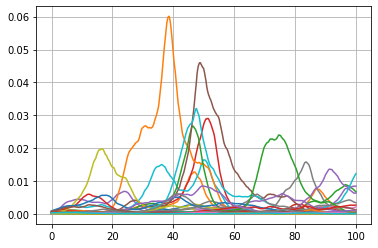

RUN  0 , total integrated cost =  30.056328767799766
Gradient descend method:  None
RUN  1 , total integrated cost =  30.054382656284407
RUN  2 , total integrated cost =  30.05457803498615
RUN  3 , total integrated cost =  10.855221505957719
RUN  4 , total integrated cost =  10.20646559885299
RUN  5 , total integrated cost =  8.36189957700853
RUN  6 , total integrated cost =  7.63760133138158
RUN  7 , total integrated cost =  7.141947739565064
RUN  8 , total integrated cost =  7.0504011482504465
RUN  9 , total integrated cost =  6.652591594661317
RUN  10 , total integrated cost =  6.428104669486197
RUN  10 , total integrated cost mean =  6.428104669486197
Improved over  10  iterations in  24.408417419001125  seconds by  78.61314094896109  percent.


In [27]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

mean_cost[1] = []
cost.setParams(w_p[i], w_e, w_s)

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M2')
    
control_list[1] = bestControl[i]
cost_list[1] = cost_[i]

In [28]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[1][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[1].append(np.mean(cost_final))
print('mean = ', mean_cost[1])

mean =  [26.637648502962453]


--------------------------------------------------------- 0
interpolate adjoint :  True True True


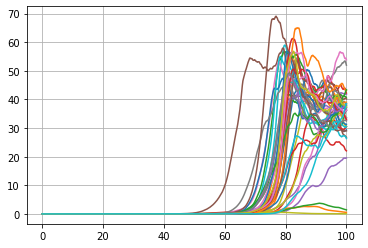

RUN  0 , total integrated cost =  29.638565029267834
Gradient descend method:  None
RUN  1 , total integrated cost =  8.46204102228991
RUN  2 , total integrated cost =  7.165789963532752
RUN  3 , total integrated cost =  6.684153724747871
RUN  4 , total integrated cost =  6.305031629517375
RUN  5 , total integrated cost =  6.188247971491222
RUN  6 , total integrated cost =  6.183278988568925
RUN  7 , total integrated cost =  6.00717406229098
RUN  8 , total integrated cost =  6.033344140447808
RUN  9 , total integrated cost =  5.941783837738079
RUN  10 , total integrated cost =  5.8972841041233774
RUN  10 , total integrated cost mean =  5.8972841041233774
Improved over  10  iterations in  25.288800639998954  seconds by  80.10266658220512  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True


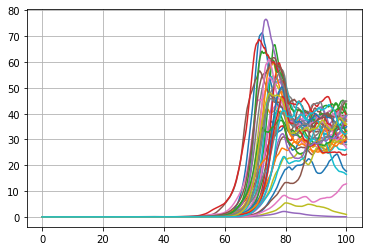

RUN  0 , total integrated cost =  11.536435389587202
Gradient descend method:  None
RUN  1 , total integrated cost =  5.973814802954888
RUN  2 , total integrated cost =  5.87603539440485
RUN  3 , total integrated cost =  5.9187058089705165
RUN  4 , total integrated cost =  5.7660030324702
RUN  5 , total integrated cost =  5.83149169567266
RUN  6 , total integrated cost =  5.9576737946289695
RUN  7 , total integrated cost =  5.792769164289773
RUN  8 , total integrated cost =  5.901521185193792
RUN  9 , total integrated cost =  5.7251831082081655
RUN  10 , total integrated cost =  5.710335698018629
RUN  10 , total integrated cost mean =  5.710335698018629
Improved over  10  iterations in  22.66882684600023  seconds by  50.50173207598611  percent.
--------------------------------------------------------- 2
interpolate adjoint :  True True True


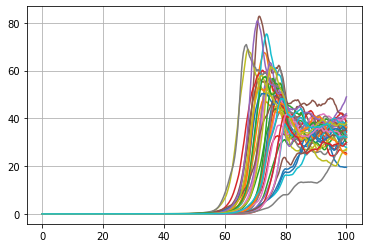

RUN  0 , total integrated cost =  6.7518069141321035
Gradient descend method:  None
RUN  1 , total integrated cost =  5.718195650104304
RUN  2 , total integrated cost =  5.8175351756565945
RUN  3 , total integrated cost =  5.887330641868044
RUN  4 , total integrated cost =  5.730354008214484
RUN  5 , total integrated cost =  5.861188091713666
RUN  6 , total integrated cost =  5.8165947441316135
RUN  7 , total integrated cost =  5.8506448411999195
no cost improvement
RUN  8 , total integrated cost =  5.960274889416567
RUN  9 , total integrated cost =  5.923264763414629
RUN  10 , total integrated cost =  5.87369558092889
RUN  10 , total integrated cost mean =  5.87369558092889
Improved over  10  iterations in  22.537356241000452  seconds by  13.00557531296181  percent.
--------------------------------------------------------- 3
interpolate adjoint :  True True True


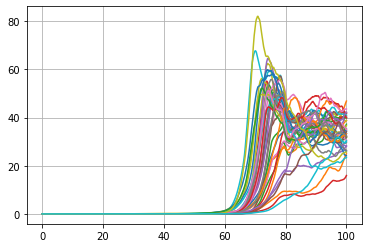

RUN  0 , total integrated cost =  8.208254083767581
Gradient descend method:  None
RUN  1 , total integrated cost =  5.680821019204411
RUN  2 , total integrated cost =  5.756224291423911
RUN  3 , total integrated cost =  5.662760242532812
RUN  4 , total integrated cost =  5.790574087262347
RUN  5 , total integrated cost =  5.751324418602769
no cost improvement
RUN  6 , total integrated cost =  5.809676710259331
RUN  7 , total integrated cost =  5.8173856907575905
RUN  8 , total integrated cost =  5.6833144125207244
RUN  9 , total integrated cost =  5.778142178952847
RUN  10 , total integrated cost =  5.673646404700778
RUN  10 , total integrated cost mean =  5.673646404700778
Improved over  10  iterations in  26.023573406999276  seconds by  30.878767313979395  percent.
--------------------------------------------------------- 4
interpolate adjoint :  True True True


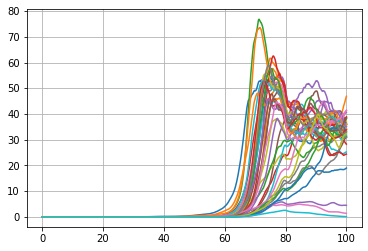

RUN  0 , total integrated cost =  11.766932933802625
Gradient descend method:  None
RUN  1 , total integrated cost =  5.749190278015797
RUN  2 , total integrated cost =  5.674681088660565
RUN  3 , total integrated cost =  5.617990392580925
RUN  4 , total integrated cost =  5.8305909731867
RUN  5 , total integrated cost =  5.768388496838428
no cost improvement
RUN  6 , total integrated cost =  5.690554539444596
RUN  7 , total integrated cost =  5.691787404524625
RUN  7 , total integrated cost mean =  5.691787404524625
Improved over  7  iterations in  31.679931663999014  seconds by  51.62896366840041  percent.
--------------------------------------------------------- 5
interpolate adjoint :  True True True


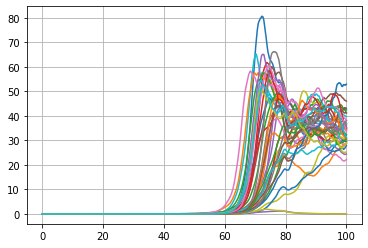

RUN  0 , total integrated cost =  12.563050777037393
Gradient descend method:  None
RUN  1 , total integrated cost =  5.553334902590062
RUN  2 , total integrated cost =  5.9105616155770235
RUN  3 , total integrated cost =  5.767105271889575
RUN  4 , total integrated cost =  5.591308519140073
RUN  5 , total integrated cost =  5.701051606736131
RUN  6 , total integrated cost =  5.639062104398524
RUN  7 , total integrated cost =  5.679705998259882
RUN  8 , total integrated cost =  5.754158204288896
RUN  9 , total integrated cost =  5.632024462447921
RUN  10 , total integrated cost =  5.639965711902716
RUN  10 , total integrated cost mean =  5.639965711902716
Improved over  10  iterations in  45.13812545300061  seconds by  55.10671880582236  percent.
--------------------------------------------------------- 6
interpolate adjoint :  True True True


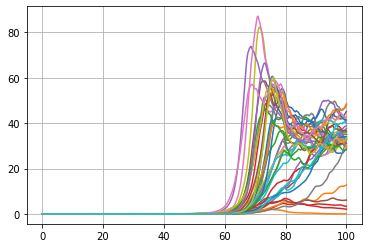

RUN  0 , total integrated cost =  15.01084946167052
Gradient descend method:  None
RUN  1 , total integrated cost =  5.836880114222078
RUN  2 , total integrated cost =  5.809581585483558
RUN  3 , total integrated cost =  5.776336190447846
RUN  4 , total integrated cost =  5.664135024408414
RUN  5 , total integrated cost =  5.705133959210828
RUN  6 , total integrated cost =  5.640850868010936
RUN  7 , total integrated cost =  5.565586061739049
RUN  8 , total integrated cost =  5.614609827943665
RUN  9 , total integrated cost =  5.716244131367302
RUN  10 , total integrated cost =  5.481847421456262
RUN  10 , total integrated cost mean =  5.481847421456262
Improved over  10  iterations in  39.78623628099922  seconds by  63.480764793132494  percent.
--------------------------------------------------------- 7
interpolate adjoint :  True True True


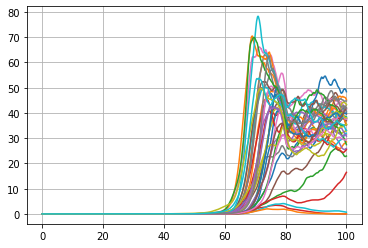

RUN  0 , total integrated cost =  13.867800395823394
Gradient descend method:  None
RUN  1 , total integrated cost =  5.506519560915363
RUN  2 , total integrated cost =  5.603524648481414
RUN  3 , total integrated cost =  5.647024785821365
RUN  4 , total integrated cost =  5.607143379495862
RUN  5 , total integrated cost =  5.60338642899953
no cost improvement
RUN  6 , total integrated cost =  5.6598934294397605
RUN  7 , total integrated cost =  5.613806264810387
RUN  8 , total integrated cost =  5.829571798302753
RUN  9 , total integrated cost =  5.595005425245054
RUN  10 , total integrated cost =  5.81028004042692
RUN  10 , total integrated cost mean =  5.81028004042692
Improved over  10  iterations in  40.036158699000225  seconds by  58.10236753784819  percent.
--------------------------------------------------------- 8
interpolate adjoint :  True True True


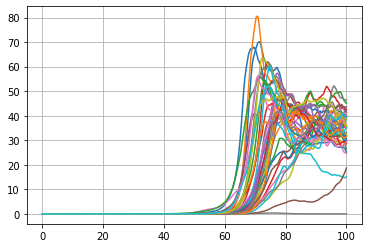

RUN  0 , total integrated cost =  11.17715754748397
Gradient descend method:  None
RUN  1 , total integrated cost =  5.514638738494645
RUN  2 , total integrated cost =  5.6160822181544505
RUN  3 , total integrated cost =  5.584469294085254
RUN  4 , total integrated cost =  5.548931450770162
RUN  5 , total integrated cost =  5.555891253696101
RUN  6 , total integrated cost =  5.594028401000147
RUN  7 , total integrated cost =  5.628785234995158
no cost improvement
RUN  8 , total integrated cost =  5.456762947300739
RUN  8 , total integrated cost mean =  5.456762947300739
Improved over  8  iterations in  33.44481455499954  seconds by  51.17933227550254  percent.
--------------------------------------------------------- 9
interpolate adjoint :  True True True


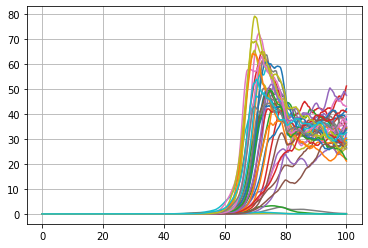

RUN  0 , total integrated cost =  17.571239174852487
Gradient descend method:  None
RUN  1 , total integrated cost =  5.416474378444931
RUN  2 , total integrated cost =  5.5203975372241825
RUN  3 , total integrated cost =  5.591754208853946
RUN  4 , total integrated cost =  5.5260806566730425
RUN  5 , total integrated cost =  5.74795831940367
no cost improvement
RUN  6 , total integrated cost =  5.605216371164181
RUN  7 , total integrated cost =  5.7628264685075274
RUN  8 , total integrated cost =  5.754528413525947
RUN  9 , total integrated cost =  5.586555744634449
RUN  10 , total integrated cost =  5.555506993437345
RUN  10 , total integrated cost mean =  5.555506993437345
Improved over  10  iterations in  40.40678206300072  seconds by  68.38295274366166  percent.
--------------------------------------------------------- 10
interpolate adjoint :  True True True


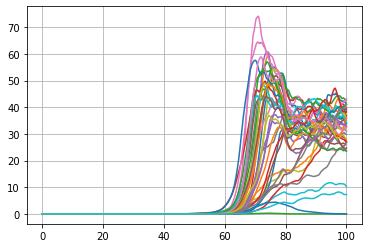

RUN  0 , total integrated cost =  13.580281023866638
Gradient descend method:  None
RUN  1 , total integrated cost =  5.674617598257673
RUN  2 , total integrated cost =  5.579112327163189
RUN  3 , total integrated cost =  5.561464785911865
RUN  4 , total integrated cost =  5.674472755503922
RUN  5 , total integrated cost =  5.6062707915157235
RUN  6 , total integrated cost =  5.6764168096302425
no cost improvement
RUN  7 , total integrated cost =  5.536041222847422
RUN  7 , total integrated cost mean =  5.536041222847422
Improved over  7  iterations in  26.118089268000404  seconds by  59.234707933376946  percent.
--------------------------------------------------------- 11
interpolate adjoint :  True True True


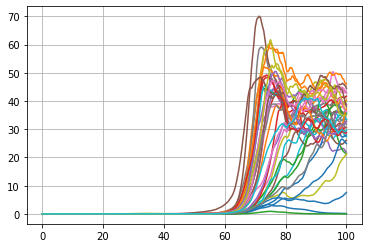

RUN  0 , total integrated cost =  15.262030343343223
Gradient descend method:  None
RUN  1 , total integrated cost =  5.71160939735667
RUN  2 , total integrated cost =  5.849320572636493
RUN  3 , total integrated cost =  5.802654829407015
RUN  4 , total integrated cost =  5.601183141759053
RUN  5 , total integrated cost =  5.746995980852757
RUN  6 , total integrated cost =  5.697166900503558
RUN  7 , total integrated cost =  5.490960118596609
RUN  8 , total integrated cost =  5.714291040794367
RUN  9 , total integrated cost =  5.547683166888102
RUN  10 , total integrated cost =  5.75485773666693
RUN  10 , total integrated cost mean =  5.75485773666693
Improved over  10  iterations in  36.731816498000626  seconds by  62.29297408534506  percent.
--------------------------------------------------------- 12
interpolate adjoint :  True True True


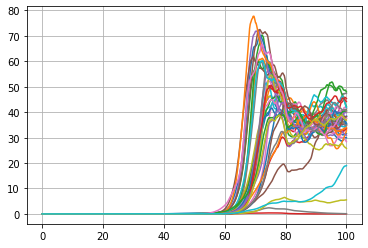

RUN  0 , total integrated cost =  13.102353249455993
Gradient descend method:  None
RUN  1 , total integrated cost =  5.663970468586073
RUN  2 , total integrated cost =  5.613899326928293
RUN  3 , total integrated cost =  5.5408829496365515
RUN  4 , total integrated cost =  5.599465739882278
RUN  5 , total integrated cost =  5.743546180102821
RUN  6 , total integrated cost =  5.5237633838184435
RUN  7 , total integrated cost =  5.660652991280268
RUN  8 , total integrated cost =  5.608223326964556
RUN  9 , total integrated cost =  5.625462615947461
RUN  10 , total integrated cost =  5.652687878785156
no cost improvement
RUN  10 , total integrated cost mean =  5.652687878785156
Improved over  10  iterations in  39.2224067620009  seconds by  56.85746086093462  percent.
--------------------------------------------------------- 13
interpolate adjoint :  True True True


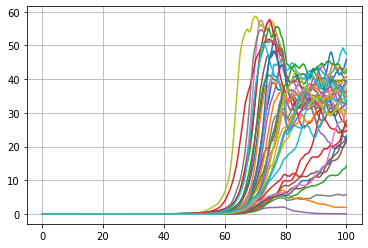

RUN  0 , total integrated cost =  14.664690967793138
Gradient descend method:  None
RUN  1 , total integrated cost =  5.624935355782869
RUN  2 , total integrated cost =  5.629125038062741
RUN  3 , total integrated cost =  5.635941290690836
RUN  4 , total integrated cost =  5.655120915048785
RUN  5 , total integrated cost =  5.591947592018764
RUN  6 , total integrated cost =  5.491867387613338
RUN  7 , total integrated cost =  5.561652812509221
RUN  8 , total integrated cost =  5.552906393078449
RUN  9 , total integrated cost =  5.58758282479804
RUN  10 , total integrated cost =  5.651631929691605
RUN  10 , total integrated cost mean =  5.651631929691605
Improved over  10  iterations in  40.478663984999  seconds by  61.46095446468104  percent.
--------------------------------------------------------- 14
interpolate adjoint :  True True True


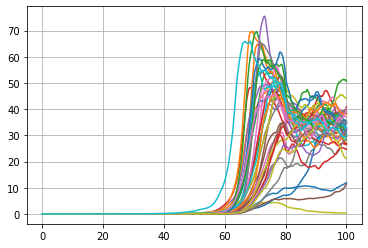

RUN  0 , total integrated cost =  9.716684445300716
Gradient descend method:  None
RUN  1 , total integrated cost =  5.616337524786394
RUN  2 , total integrated cost =  5.564470021481574
RUN  3 , total integrated cost =  5.557458850048163
RUN  4 , total integrated cost =  5.777425910674698
RUN  5 , total integrated cost =  5.587351398248237
RUN  6 , total integrated cost =  5.615806978570902
RUN  7 , total integrated cost =  5.805879200293719
no cost improvement
RUN  8 , total integrated cost =  5.669986616418705
RUN  9 , total integrated cost =  5.72068945957949
RUN  10 , total integrated cost =  5.68011083719029
RUN  10 , total integrated cost mean =  5.68011083719029
Improved over  10  iterations in  41.04336797299948  seconds by  41.54270554769982  percent.
--------------------------------------------------------- 15
interpolate adjoint :  True True True


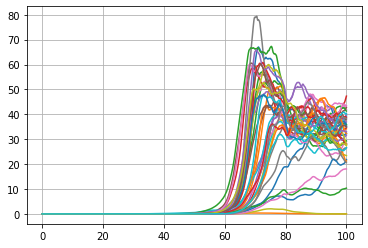

RUN  0 , total integrated cost =  13.285147568211908
Gradient descend method:  None
RUN  1 , total integrated cost =  5.401815150080042
RUN  2 , total integrated cost =  5.416785619388814
RUN  3 , total integrated cost =  5.468190954841122
RUN  4 , total integrated cost =  5.490044007107967
RUN  5 , total integrated cost =  5.468237121222242
no cost improvement
RUN  6 , total integrated cost =  5.5364026955190155
RUN  7 , total integrated cost =  5.756861393861013
RUN  8 , total integrated cost =  5.6254028806855105
RUN  9 , total integrated cost =  5.7822413200144736
RUN  10 , total integrated cost =  5.686996977245514
RUN  10 , total integrated cost mean =  5.686996977245514
Improved over  10  iterations in  42.77367316799973  seconds by  57.19282041809532  percent.
--------------------------------------------------------- 16
interpolate adjoint :  True True True


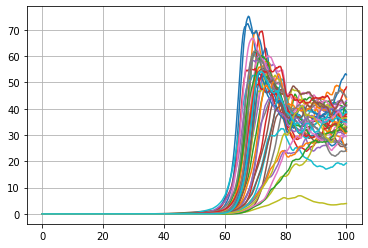

RUN  0 , total integrated cost =  7.393811935464609
Gradient descend method:  None
RUN  1 , total integrated cost =  5.554303528101205
RUN  2 , total integrated cost =  5.590086883663716
RUN  3 , total integrated cost =  5.6430110883942755
RUN  4 , total integrated cost =  5.701235709459576
RUN  5 , total integrated cost =  5.841266034609007
no cost improvement
RUN  6 , total integrated cost =  5.702576352245354
RUN  7 , total integrated cost =  5.622505578959826
RUN  7 , total integrated cost mean =  5.622505578959826
Improved over  7  iterations in  36.28668371800086  seconds by  23.95660549612664  percent.
--------------------------------------------------------- 17
interpolate adjoint :  True True True


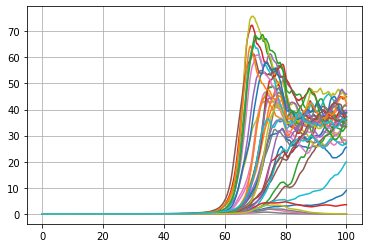

RUN  0 , total integrated cost =  20.61951763503413
Gradient descend method:  None
RUN  1 , total integrated cost =  5.5731849970011575
RUN  2 , total integrated cost =  5.592136555560463
RUN  3 , total integrated cost =  5.5245414798350225
RUN  4 , total integrated cost =  5.491809034803934
RUN  5 , total integrated cost =  5.665120966107211
RUN  6 , total integrated cost =  5.556195344032603
RUN  7 , total integrated cost =  5.68037852407932
no cost improvement
RUN  8 , total integrated cost =  5.703414827273977
RUN  9 , total integrated cost =  5.682218535089388
RUN  10 , total integrated cost =  5.772190218312997
RUN  10 , total integrated cost mean =  5.772190218312997
Improved over  10  iterations in  43.910129715999574  seconds by  72.00618210143962  percent.
--------------------------------------------------------- 18
interpolate adjoint :  True True True


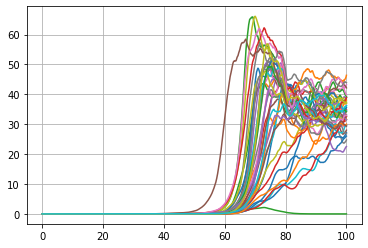

RUN  0 , total integrated cost =  9.862765649916431
Gradient descend method:  None
RUN  1 , total integrated cost =  5.737510304060004
RUN  2 , total integrated cost =  5.677388671820569
RUN  3 , total integrated cost =  5.606578888155733
RUN  4 , total integrated cost =  5.584617250293006
RUN  5 , total integrated cost =  5.6539149866442555
RUN  6 , total integrated cost =  5.653126652605896
RUN  7 , total integrated cost =  5.861845674055483
no cost improvement
RUN  8 , total integrated cost =  5.761922639990692
RUN  9 , total integrated cost =  5.700992938168892
RUN  10 , total integrated cost =  5.499210326036595
RUN  10 , total integrated cost mean =  5.499210326036595
Improved over  10  iterations in  52.19269869399977  seconds by  44.24271526634935  percent.
mean =  [26.637648502962453, 10.506828435148366, 11.6128763115371, 10.783002701728826, 11.40451437302385, 14.525152406427674, 12.88894024471157, 14.540114632581565, 13.763948636418425, 14.800166013053675, 15.686086588436801,

In [29]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[1][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M2')

    control_list[1] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[1][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[1].append(np.mean(cost_final))

print('mean = ', mean_cost[1])

In [30]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)
mean_cost[2] = []

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M3')
    
control_list[2] = bestControl[i]
cost_list[2] = cost_[i]

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.05572794505582
Gradient descend method:  None
RUN  1 , total integrated cost =  30.058285345408002
RUN  2 , total integrated cost =  30.056997706433965
RUN  3 , total integrated cost =  11.512774043453087
RUN  4 , total integrated cost =  5.954876399525752
RUN  5 , total integrated cost =  5.9866705176966475
RUN  6 , total integrated cost =  5.973815239570541
RUN  7 , total integrated cost =  6.276282654748061
RUN  8 , total integrated cost =  6.1763526786581755
RUN  9 , total integrated cost =  6.201201873092263
RUN  10 , total integrated cost =  6.222103966661733
RUN  10 , total integrated cost mean =  6.222103966661733
Improved over  10  iterations in  41.08647058099996  seconds by  79.29810923882391  percent.


In [31]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[2][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[2].append(np.mean(cost_final))
print('mean = ', mean_cost[2])

mean =  [8.450496396914751]


In [32]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[2][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M3')

    control_list[2] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[2][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[2].append(np.mean(cost_final))

print('mean = ', mean_cost[2])

--------------------------------------------------------- 0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.534103084501044
Gradient descend method:  None
RUN  1 , total integrated cost =  6.535240499997474
RUN  2 , total integrated cost =  6.729438696092794
RUN  3 , total integrated cost =  6.590725067212512
RUN  4 , total integrated cost =  6.83010922898365
RUN  5 , total integrated cost =  6.597068437052795
RUN  6 , total integrated cost =  6.118161159631583
RUN  7 , total integrated cost =  6.5673118675720845
RUN  8 , total integrated cost =  6.399923987647187
RUN  9 , total integrated cost =  6.575595705095495
RUN  10 , total integrated cost =  6.537115679969039
RUN  10 , total integrated cost mean =  6.537115679969039
Improved over  10  iterations in  40.667896246000964  seconds by  23.400085337131372  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6.40770294345

RUN  1 , total integrated cost =  6.548552701883475
RUN  2 , total integrated cost =  6.560346998257529
RUN  3 , total integrated cost =  6.001246743546184
RUN  4 , total integrated cost =  6.047386547182557
RUN  5 , total integrated cost =  6.244440832560548
RUN  6 , total integrated cost =  6.322549597843637
RUN  7 , total integrated cost =  6.146774782740654
RUN  8 , total integrated cost =  6.3615075973147786
RUN  9 , total integrated cost =  6.2823095610870885
RUN  10 , total integrated cost =  6.317868694168887
no cost improvement
RUN  10 , total integrated cost mean =  6.317868694168887
Improved over  10  iterations in  40.428449869999895  seconds by  2.5973750644012057  percent.
--------------------------------------------------------- 11
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.90073921077045
Gradient descend method:  None
RUN  1 , total integrated cost =  6.39325418245639
RUN  2 , total integrated cost =  6.448602676111912
RUN  3 , total integ

In [33]:
aln.params.duration = dur
zero_init = aln.getZeroControl()

mean_cost[3] = []

##### zero control as input for uncontrolled cost
setinit(initVars[i], aln)

bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
    zero_init, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
    control_variables_ = [0,1], prec_variables_ = [0], transition_time_ = trans_time,
    noise_real=noise_realizations, init_params = initVars[i], method='M4')

control_list[3] = bestControl[i]
cost_list[3] = cost_[i]

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.05466899374784
Gradient descend method:  None
RUN  1 , total integrated cost =  30.05499604336177
RUN  2 , total integrated cost =  30.05852975171613
RUN  3 , total integrated cost =  14.655772855535796
RUN  4 , total integrated cost =  14.822001235419771
RUN  5 , total integrated cost =  11.483679986724812
RUN  6 , total integrated cost =  12.36692069785602
RUN  7 , total integrated cost =  12.333406499380095
RUN  8 , total integrated cost =  10.693903137801342
RUN  9 , total integrated cost =  10.739452162875704
RUN  10 , total integrated cost =  12.812388980702076
RUN  10 , total integrated cost mean =  12.812388980702076
Improved over  10  iterations in  34.00835424100114  seconds by  57.369721877930544  percent.


In [34]:
aln.params.duration = dur
init_control = aln.getZeroControl()           
init_control[:,:,:] = control_list[3][:,:,100:-100]

cost_final = np.zeros(( noise_realizations_final ))

for n_ in range(noise_realizations_final):

    setinit(initVars[i], aln)
    state_ = fo.updateState(aln, init_control)
    cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
    cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

mean_cost[3].append(np.mean(cost_final))
print('mean = ', mean_cost[3])

mean =  [34.827601836922675]


In [35]:
for k_ in range(19):
    print('---------------------------------------------------------', k_)
    setinit(initVars[i], aln)
    
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[3][:,:,100:-100]

    bestControl[i], bestState[i], cost_[i], runtime[i], grad[i], phi[i], costnode[i], total_cost_mean_std = aln.A1(
        init_control, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it,
        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
        control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
        noise_real=noise_realizations, init_params = initVars[i], method='M4')

    control_list[3] = bestControl[i]

    aln.params.duration = dur
    init_control = aln.getZeroControl()           
    init_control[:,:,:] = control_list[3][:,:,100:-100]

    cost_final = np.zeros(( noise_realizations_final ))

    for n_ in range(noise_realizations_final):

        setinit(initVars[i], aln)
        state_ = fo.updateState(aln, init_control)
        cost_final[n_] += cost.numba_cost_precision_int(1,T,dt,w_p[i],state_, target_, list(prec_vars) )
        cost_final[n_] += cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

    mean_cost[3].append(np.mean(cost_final))

print('mean = ', mean_cost[3])

--------------------------------------------------------- 0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  40.10526783356965
Gradient descend method:  None
RUN  1 , total integrated cost =  16.643377072662965
RUN  2 , total integrated cost =  19.734945980745294
RUN  3 , total integrated cost =  12.965320934890334
RUN  4 , total integrated cost =  8.783242833584495
RUN  5 , total integrated cost =  7.5228584236230915
RUN  6 , total integrated cost =  10.813589085840658
RUN  7 , total integrated cost =  16.143529887635214
RUN  8 , total integrated cost =  8.732594222338488
RUN  9 , total integrated cost =  10.244791802626995
RUN  10 , total integrated cost =  6.950226080809803
RUN  10 , total integrated cost mean =  6.950226080809803
Improved over  10  iterations in  32.40515954500006  seconds by  82.67004197640043  percent.
--------------------------------------------------------- 1
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.555608

RUN  10 , total integrated cost =  8.142461030210958
RUN  10 , total integrated cost mean =  8.142461030210958
Improved over  10  iterations in  17.418457521000164  seconds by  35.62762955389202  percent.
--------------------------------------------------------- 10
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8.176460078618138
Gradient descend method:  None
RUN  1 , total integrated cost =  8.064292085492784
RUN  2 , total integrated cost =  7.816337409994034
RUN  3 , total integrated cost =  7.826859618283349
RUN  4 , total integrated cost =  10.334573674767656
RUN  5 , total integrated cost =  7.741385480088331
RUN  6 , total integrated cost =  9.2172255394851
RUN  7 , total integrated cost =  10.649527391481692
no cost improvement
RUN  8 , total integrated cost =  8.24127106244617
RUN  9 , total integrated cost =  10.238619835469597
RUN  10 , total integrated cost =  8.608390321266985
RUN  10 , total integrated cost mean =  8.608390321266985
Improved over 

------
-0.39647310433057864
-0.314353202391162
-0.20918139825908116
-0.16824113527536233
-0.20571714899917978
-0.11569596234396888
-0.05342286822401794
-0.10691666767453736
-0.09963952035835405
0.0033215108688086008
0.13217487211248302
-0.22718018425704425
-0.23831031974071284
-0.5163638505027621
-0.627962570304046
-0.30821220878578626
0.08852615976129251
-0.482560482860005
------
0.1494354713453282
0.8012030226598439
0.7633395426375942
0.7262091527011666
0.6599951505904499
0.5684947806914508
0.5842107872726139
0.4917310032992503
0.4799975408166644
0.3896020804050708
0.3644133334373447
0.4396256759992042
0.4913600048570035
0.3181111511664097
0.6347134430668987
0.5225697695525002
0.9296144817726196
0.822352389978883
------
-0.5840825042581197
-0.4979877747566277
-0.3875757061361875
-0.4610939988600926
-0.3440703572018623
-0.40732453029014903
-0.4419425326258459
-0.12105823303436367
-0.22868588330339493
-0.3199841367646732
0.3467342182580791
0.28423069645726035
0.10100319789838182
0.0855

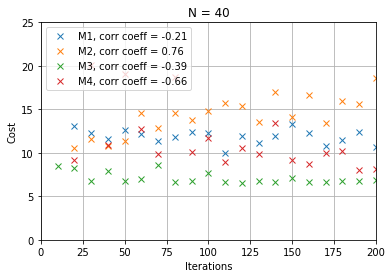

In [40]:
color = ['red', 'green', 'blue', 'orange']
l_ = ['M1', 'M2', 'M3', 'M4']

for k in range(4):
    x = np.arange(10,10*len(mean_cost[k])+1, 10)
    y = mean_cost[k]
    plt.plot( x,y, label=l_[k] + ', corr coeff = {:.2f}'.format(np.corrcoef(x[2:],y[2:])[0,1]),
             linestyle='', marker='x' )
    print('------')
    for k_ in np.arange(0,len(mean_cost[k])-2,1):
        print(np.corrcoef(x[k_:],y[k_:])[0,1])
    
plt.legend(loc='upper left')
plt.title('N = {}'.format(noise_realizations))

plt.ylim(0,25)
plt.xlim(0,200)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('method_compare_' + str(noise_realizations) + '.png')
plt.show()